Author: Saleem A. Al Dajani

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 3.4 MB/s eta 0:00:00


In [ ]:
# --- 📦 LIBRARIES ---
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score

# --- 📂 PATHS ---
metadata_path = "/content/drive/MyDrive/Gladyshev/data/master_metadata_with_gender.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/imdb_crop_filtered_final_unzip"

# --- 📋 LOAD METADATA ---
df_meta = pd.read_csv(metadata_path)
df_meta = df_meta.drop(columns=["image_file"], errors="ignore")
df_meta = df_meta.dropna(subset=["imdb_id", "time_to_death_at_face", "age_at_face"])
df_meta["imdb_id"] = df_meta["imdb_id"].astype(str)

print(f"✅ Metadata loaded: {df_meta.shape[0]} rows across {df_meta.shape[1]} features")

# --- ⚙️ ENCODER FOR CAUSE OF DEATH ---
df_meta["cause_of_death"] = df_meta["cause_of_death"].fillna("unknown")
cause_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cause_encoder.fit(df_meta[["cause_of_death"]].values)

# --- 🖼️ PARSE IMAGE FILENAMES ---
def extract_image_info(fname):
    try:
        match = re.match(r"(nm\d+)_.*_(\d{4})-(\d{1,2})-(\d{1,2})_(\d{4})\.jpg", fname)
        if not match:
            return None
        imdb_id, y, m, d, photo_year = match.groups()
        dob = datetime(int(y), int(m), int(d))
        age_at_face = int(photo_year) - dob.year
        return {
            "imdb_id": imdb_id,
            "photo_year": int(photo_year),
            "dob": dob,
            "age_at_face": age_at_face,
            "image_file": fname
        }
    except:
        return None

image_data = [extract_image_info(f) for f in os.listdir(image_dir) if f.endswith(".jpg")]
image_data = [d for d in image_data if d is not None]
df_imgs = pd.DataFrame(image_data)

# --- 🔄 MATCH IMAGES TO METADATA ROWS BY IMDB ID AND CLOSEST AGE ---
matched = []
for _, row in tqdm(df_meta.iterrows(), total=len(df_meta), desc="🔄 Matching images to metadata"):
    subset = df_imgs[df_imgs["imdb_id"] == row["imdb_id"]].copy()
    if subset.empty:
        continue
    subset["age_diff"] = np.abs(subset["age_at_face"] - row["age_at_face"])
    closest = subset[subset["age_diff"] <= 1].sort_values("age_diff").head(1)
    if not closest.empty:
        matched.append({**row.to_dict(), "image_file": closest["image_file"].values[0]})

df_images = pd.DataFrame(matched)
print(f"✅ Matched {len(df_images)} metadata rows with images")

# --- 🪠 FEATURE EXTRACTION FUNCTION ---
def load_image_and_features(row, size=(64, 64)):
    try:
        img_path = os.path.join(image_dir, row["image_file"])
        img = Image.open(img_path).convert("L").resize(size)
        img_array = np.array(img).flatten()

        age_face = row["age_at_face"]
        gender = str(row.get("gender", "")).lower()
        gender_encoded = 1 if gender == "female" else 0
        cause_vector = cause_encoder.transform([[row["cause_of_death"]]]).flatten()
        metadata = np.array([age_face, gender_encoded])
        full_features = np.concatenate([img_array, metadata, cause_vector])
        return full_features, row["time_to_death_at_face"]
    except:
        return None, None

# --- ⚙️ PARALLEL IMAGE LOADING ---
print("⚙️ Loading and processing images in parallel...")
X, y = [], []
with ThreadPoolExecutor(max_workers=32) as executor:
    futures = [executor.submit(load_image_and_features, row) for _, row in df_images.iterrows()]
    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        if result[0] is not None:
            X.append(result[0])
            y.append(result[1])

X = np.array(X)
y = np.array(y)
print(f"✅ Final dataset: {len(X)} usable samples")

# --- 🔄 NORMALIZE NUMERIC METADATA (last 2 before cause_of_death one-hot) ---
n_cause = cause_encoder.transform([["unknown"]]).shape[1]
scaler = StandardScaler()
X[:, -2 - n_cause : -n_cause] = scaler.fit_transform(X[:, -2 - n_cause : -n_cause])
print(f"✅ Final feature matrix: {X.shape[0]} samples × {X.shape[1]} features")


✅ Metadata loaded: 29001 rows across 7 features


🔄 Matching images to metadata: 100%|██████████| 29001/29001 [01:27<00:00, 329.73it/s]


✅ Matched 23509 metadata rows with images
⚙️ Loading and processing images in parallel...


100%|██████████| 23509/23509 [05:27<00:00, 71.72it/s] 


✅ Final dataset: 23509 usable samples
✅ Final feature matrix: 23509 samples × 4436 features


In [ ]:
from sklearn.model_selection import StratifiedGroupKFold

# --- ⛓️ BIN TIME TO DEATH FOR STRATIFICATION ---
# Bin into 10 equal-width intervals (or adjust `n_bins` as needed)
n_bins = 10
bins = pd.qcut(y, q=n_bins, labels=False, duplicates='drop')  # quantile-based bins
groups = df_images["imdb_id"].values

# --- 🔀 STRATIFIED SPLIT ---
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in sgkf.split(X, bins, groups):
    break  # Use the first split

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
print(f"✅ Train size: {len(train_idx)} — Test size: {len(test_idx)}")


✅ Train size: 18665 — Test size: 4844


In [ ]:
import joblib

# If files are uploaded via `files.upload()` or mounted from Drive:
# from google.colab import files
# uploaded = files.upload()

# Load pickled files
X_train = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/X_train.pkl")
X_test = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/X_test.pkl")
y_train = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/y_train.pkl")
y_test = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/y_test.pkl")
best_rf = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_rf.pkl")
best_xgb = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl")
df_meta = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/df_meta.pkl")

# Optional: confirm successful loading
print("Loaded:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
print(f"df_meta: {df_meta.shape}")


Loaded:
X_train: (19734, 4436)
X_test: (3775, 4436)
y_train: (19734,)
y_test: (3775,)
df_meta: (29001, 7)


🧮 Sample counts by split and condition:
split  condition
test   1-Year         543
       Full          3640
       Point          115
train  1-Year        2031
       Full         16657
       Point          523
dtype: int64

🧮 Sample counts by split and all_condition:
split  all_condition
test   Point              115
       Year+Full         4183
train  Point              523
       Year+Full        18688
dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


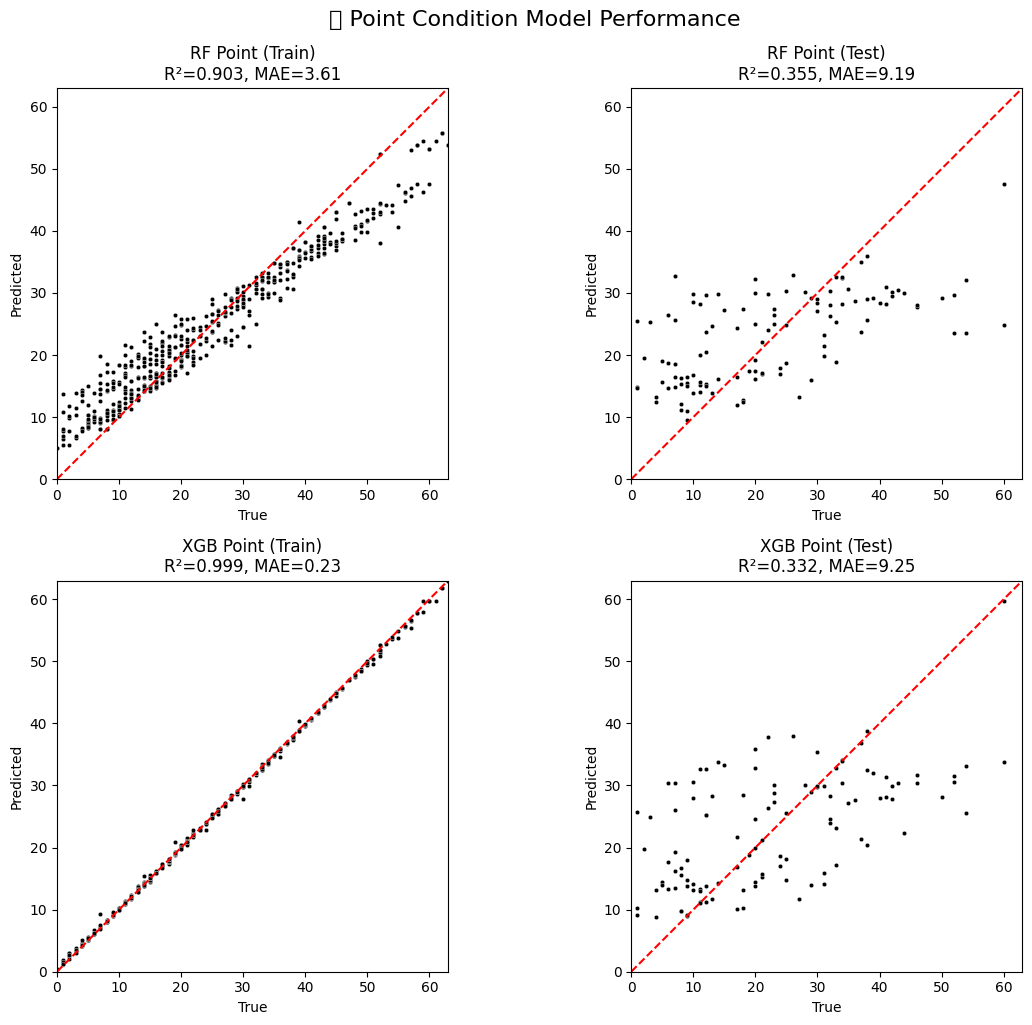

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


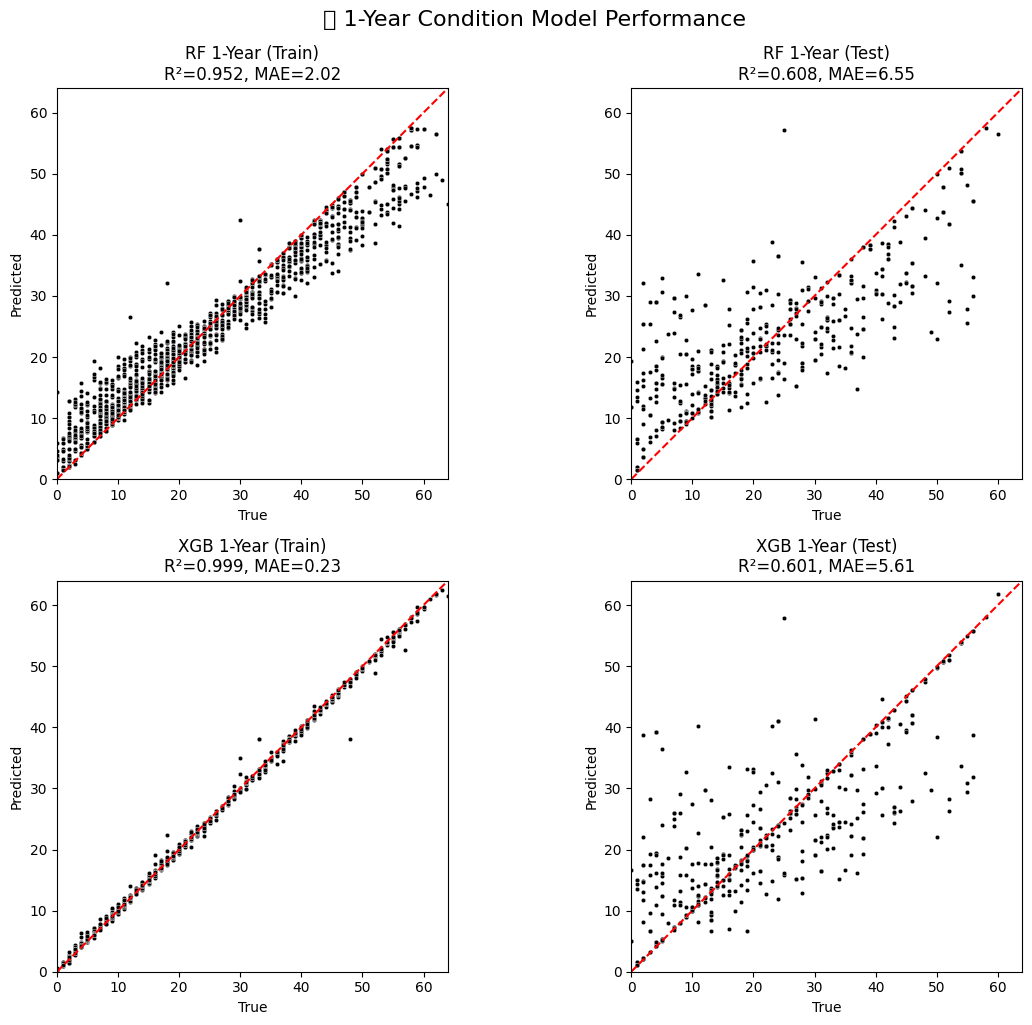

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


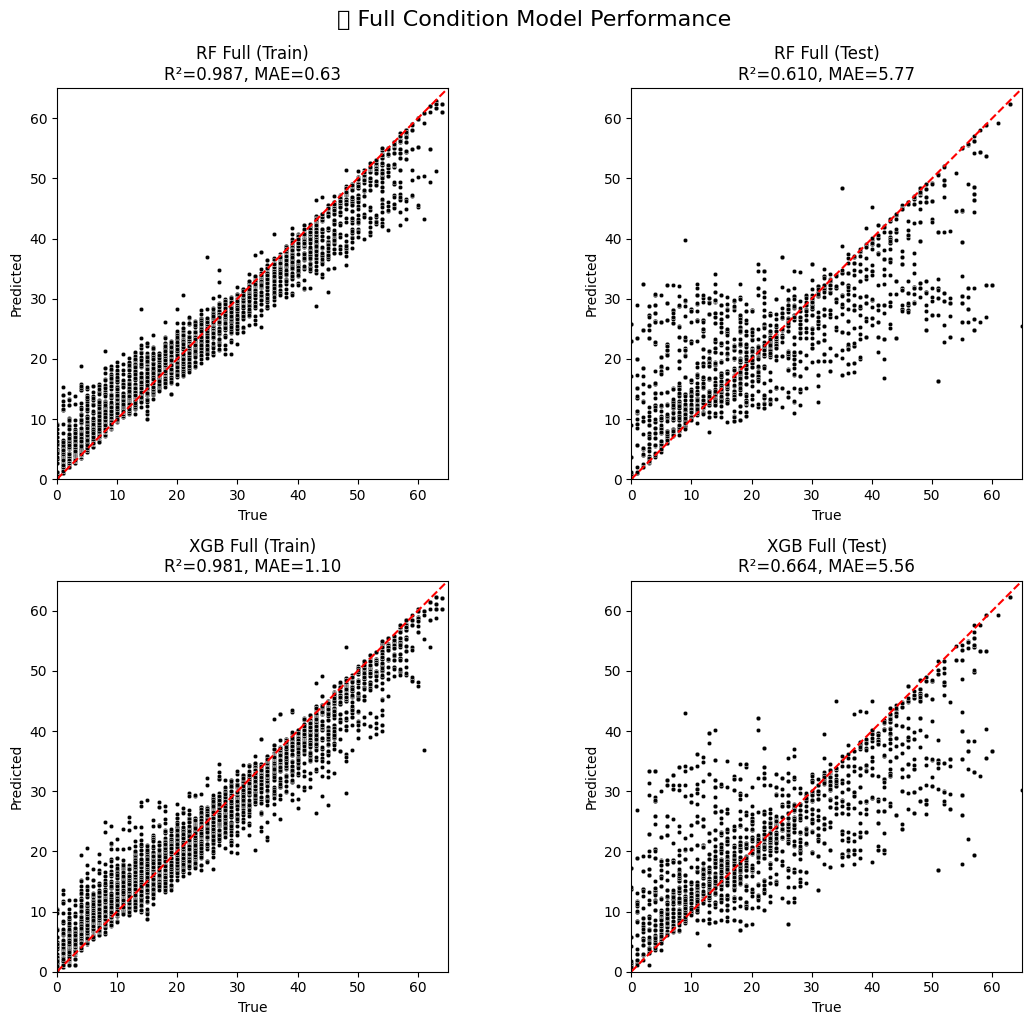

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


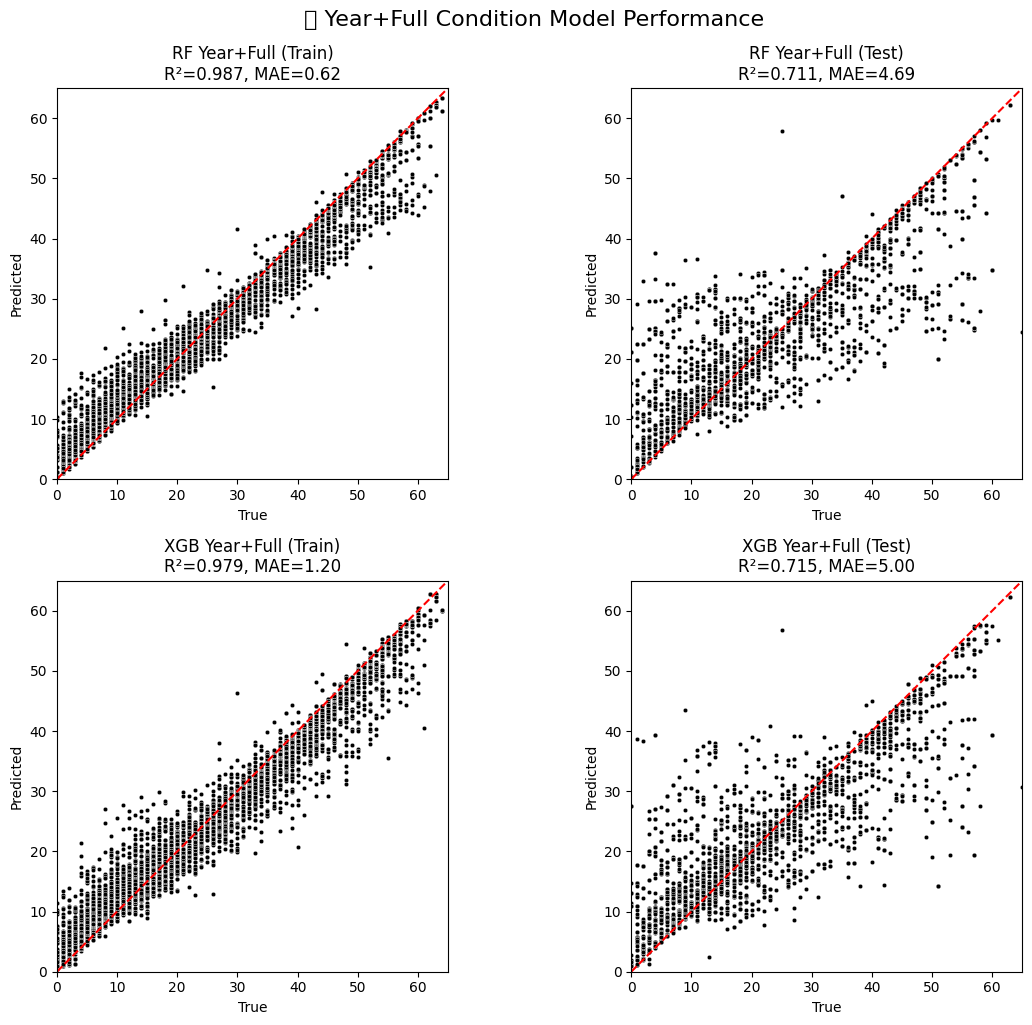

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


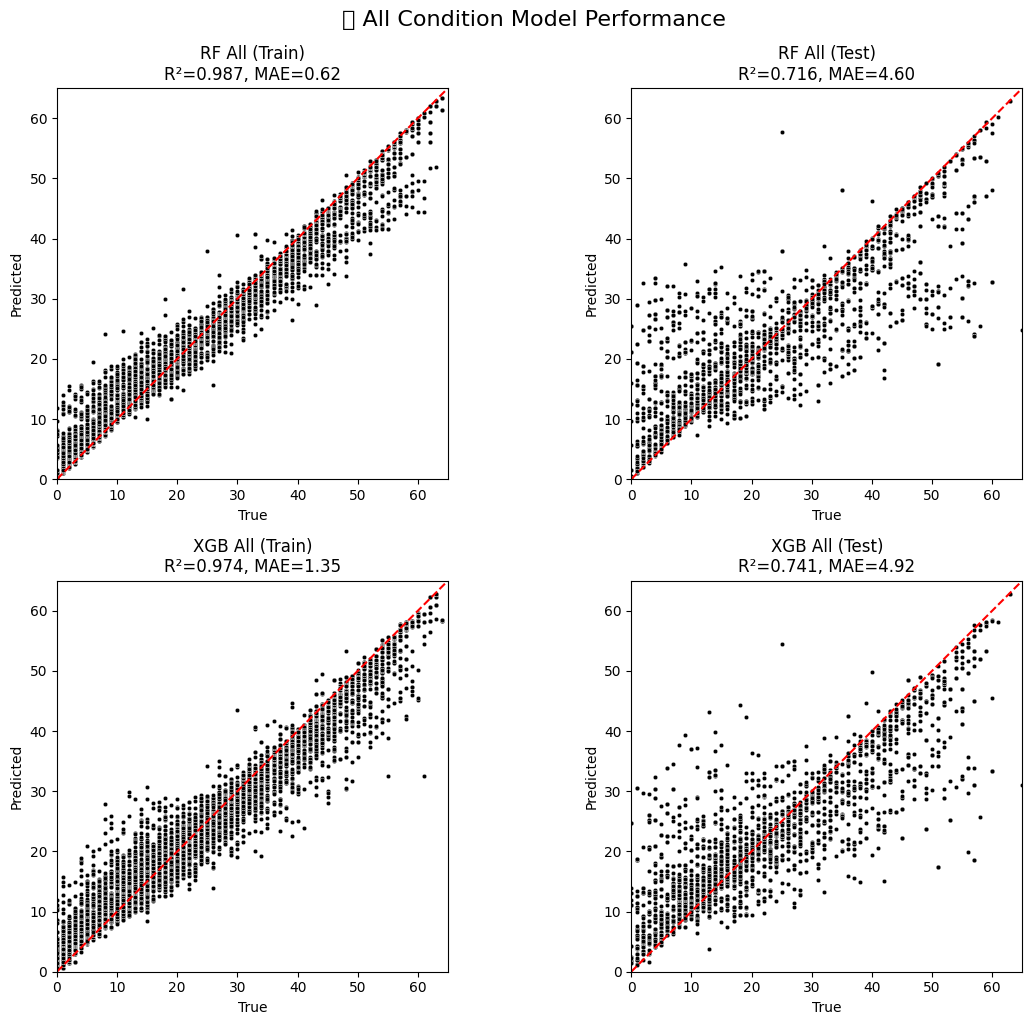

,Model,Condition,Split,R²,MAE
0,RF,1-Year,Test,0.608265,6.545346
1,RF,1-Year,Train,0.952242,2.016765
2,XGB,1-Year,Test,0.600647,5.606693
3,XGB,1-Year,Train,0.998966,0.228345
4,RF,All,Test,0.716474,4.601164
5,RF,All,Train,0.987453,0.620308
6,XGB,All,Test,0.741233,4.922450
7,XGB,All,Train,0.974138,1.345413
8,RF,Full,Test,0.610453,5.773319
9,RF,Full,Train,0.986945,0.625997


In [ ]:
# --- 📦 IMPORTS ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# --- ✅ Subset based on split indices ---
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# --- 🧠 Attach indices to metadata ---
df_meta_cond = df_images.copy()
df_meta_cond["true"] = y  # full target vector
df_meta_cond["split"] = "test"
df_meta_cond.loc[train_idx, "split"] = "train"

# --- ⏳ CLASSIFY TRAJECTORY TYPE (final logic) ---
span_df = df_meta_cond.groupby("imdb_id")["age_at_face"].agg(["min", "max", "count"])
span_df["span"] = span_df["max"] - span_df["min"]
span_df["condition"] = "Point"
span_df.loc[(span_df["count"] > 1) & (span_df["span"] <= 1), "condition"] = "1-Year"
span_df.loc[(span_df["count"] > 1) & (span_df["span"] > 1), "condition"] = "Full"
span_df["all_condition"] = "Point"
span_df.loc[(span_df["count"] > 1), "all_condition"] = "Year+Full"

df_meta_cond = df_meta_cond.drop(columns=["condition"], errors="ignore")
df_meta_cond = df_meta_cond.merge(span_df[["condition", "all_condition"]], left_on="imdb_id", right_index=True)

print("🧮 Sample counts by split and condition:")
print(df_meta_cond.groupby(["split", "condition"]).size())
print("\n🧮 Sample counts by split and all_condition:")
print(df_meta_cond.groupby(["split", "all_condition"]).size())

# --- 🔁 Loop over all conditions (including All)
conditions = ["Point", "1-Year", "Full", "Year+Full", "All"]
results_all = []

for cond in conditions:
    if cond == "Year+Full":
        df_train = df_meta_cond[(df_meta_cond["split"] == "train") & (df_meta_cond["all_condition"] == cond)].copy()
        df_test = df_meta_cond[(df_meta_cond["split"] == "test") & (df_meta_cond["all_condition"] == cond)].copy()
    elif cond == "All":
        df_train = df_meta_cond[df_meta_cond["split"] == "train"].copy()
        df_test = df_meta_cond[df_meta_cond["split"] == "test"].copy()
    else:
        df_train = df_meta_cond[(df_meta_cond["split"] == "train") & (df_meta_cond["condition"] == cond)].copy()
        df_test = df_meta_cond[(df_meta_cond["split"] == "test") & (df_meta_cond["condition"] == cond)].copy()

    if df_train.empty or df_test.empty:
        print(f"⚠️ Skipping {cond}: not enough samples.")
        continue

    xtr = X[df_train.index]
    ytr = df_train["true"].values
    xte = X[df_test.index]
    yte = df_test["true"].values

    # --- 🔁 Fit Models with Best Params ---
    rf_params = best_rf.get_params()
    rf_params.pop("n_jobs", None)
    rf_params.pop("random_state", None)
    rf_model = RandomForestRegressor(**rf_params, n_jobs=-1, random_state=42)
    rf_model.fit(xtr, ytr)

    xgb_params = best_xgb.get_params()
    xgb_params.pop("n_jobs", None)
    xgb_params.pop("verbosity", None)
    xgb_params.pop("random_state", None)
    xgb_model = XGBRegressor(**xgb_params, n_jobs=-1, verbosity=0, random_state=42)
    xgb_model.fit(xtr, ytr)

    # --- 📈 Plotting ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    all_true = np.concatenate([ytr, yte])
    axis_min, axis_max = np.floor(all_true.min()), np.ceil(all_true.max())

    for i, (model_name, model) in enumerate({"RF": rf_model, "XGB": xgb_model}.items()):
        y_pred_train = model.predict(xtr)
        y_pred_test = model.predict(xte)

        r2_train = r2_score(ytr, y_pred_train)
        mae_train = mean_absolute_error(ytr, y_pred_train)
        r2_test = r2_score(yte, y_pred_test)
        mae_test = mean_absolute_error(yte, y_pred_test)

        results_all.extend([
            {"Model": model_name, "Condition": cond, "Split": "Train", "R²": r2_train, "MAE": mae_train},
            {"Model": model_name, "Condition": cond, "Split": "Test", "R²": r2_test, "MAE": mae_test}
        ])

        ax_tr = axes[i, 0]
        sns.scatterplot(x=ytr, y=y_pred_train, s=10, color="black", ax=ax_tr)
        ax_tr.plot([axis_min, axis_max], [axis_min, axis_max], 'r--')
        ax_tr.set_aspect("equal", "box")
        ax_tr.set_xlim(axis_min, axis_max)
        ax_tr.set_ylim(axis_min, axis_max)
        ax_tr.set_title(f"{model_name} {cond} (Train)\nR²={r2_train:.3f}, MAE={mae_train:.2f}")
        ax_tr.set_xlabel("True"); ax_tr.set_ylabel("Predicted")

        ax_te = axes[i, 1]
        sns.scatterplot(x=yte, y=y_pred_test, s=10, color="black", ax=ax_te)
        ax_te.plot([axis_min, axis_max], [axis_min, axis_max], 'r--')
        ax_te.set_aspect("equal", "box")
        ax_te.set_xlim(axis_min, axis_max)
        ax_te.set_ylim(axis_min, axis_max)
        ax_te.set_title(f"{model_name} {cond} (Test)\nR²={r2_test:.3f}, MAE={mae_test:.2f}")
        ax_te.set_xlabel("True"); ax_te.set_ylabel("Predicted")

    plt.tight_layout()
    plt.suptitle(f"📊 {cond} Condition Model Performance", fontsize=16, y=1.02)
    plt.show()

# --- 📋 Summary Table ---
df_summary = pd.DataFrame(results_all)
df_summary = df_summary.sort_values(by=["Condition", "Model", "Split"])
df_summary.reset_index(drop=True, inplace=True)
df_summary


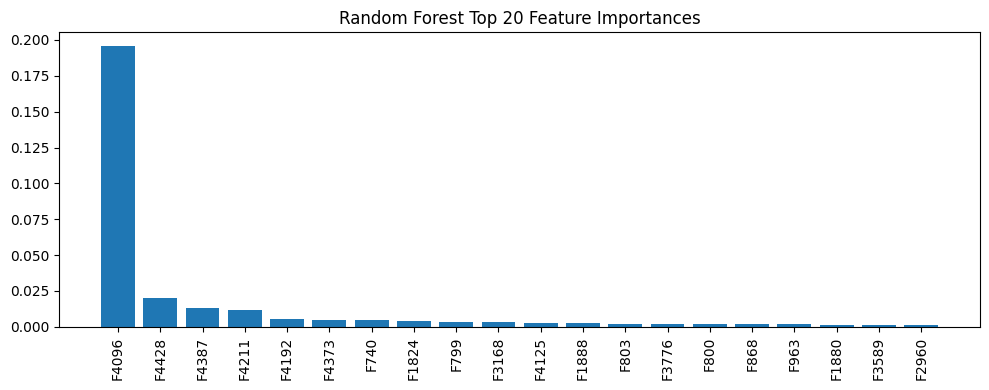

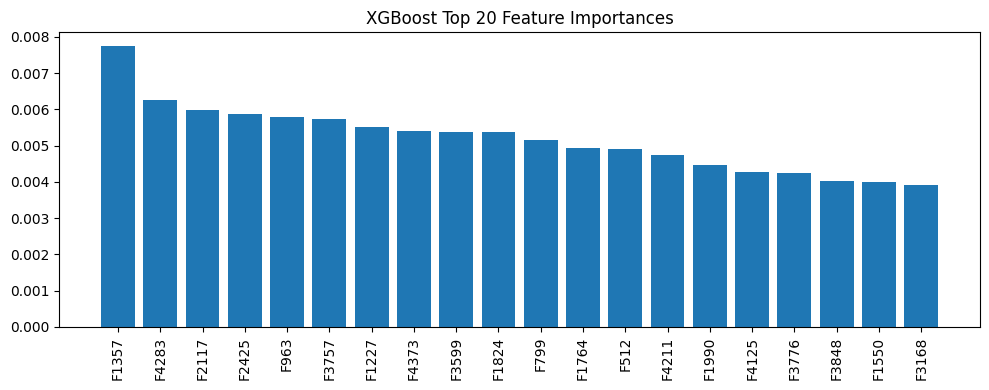

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importances(model, model_name, top_n=20):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-top_n:][::-1]
        plt.figure(figsize=(10, 4))
        plt.bar(range(top_n), importances[indices])
        plt.xticks(range(top_n), [f"F{idx}" for idx in indices], rotation=90)
        plt.title(f"{model_name} Top {top_n} Feature Importances")
        plt.tight_layout()
        plt.show()
    else:
        print(f"{model_name} does not support feature_importances_.")

# Plot for both models
plot_feature_importances(rf_model, "Random Forest")
plot_feature_importances(xgb_model, "XGBoost")


with feature importance

In [ ]:
# --- 📦 IMPORTS ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# --- ✅ Subset based on split indices ---
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# --- 🧠 Attach indices to metadata ---
df_meta_cond = df_images.copy()
df_meta_cond["true"] = y  # full target vector
df_meta_cond["split"] = "test"
df_meta_cond.loc[train_idx, "split"] = "train"

# --- ⏳ CLASSIFY TRAJECTORY TYPE (final logic) ---
span_df = df_meta_cond.groupby("imdb_id")["age_at_face"].agg(["min", "max", "count"])
span_df["span"] = span_df["max"] - span_df["min"]
span_df["condition"] = "Point"
span_df.loc[(span_df["count"] > 1) & (span_df["span"] <= 1), "condition"] = "1-Year"
span_df.loc[(span_df["count"] > 1) & (span_df["span"] > 1), "condition"] = "Full"
span_df["all_condition"] = "Point"
span_df.loc[(span_df["count"] > 1), "all_condition"] = "Year+Full"

df_meta_cond = df_meta_cond.drop(columns=["condition"], errors="ignore")
df_meta_cond = df_meta_cond.merge(span_df[["condition", "all_condition"]], left_on="imdb_id", right_index=True)

print("🧮 Sample counts by split and condition:")
print(df_meta_cond.groupby(["split", "condition"]).size())
print("\n🧮 Sample counts by split and all_condition:")
print(df_meta_cond.groupby(["split", "all_condition"]).size())

# --- 🔁 Loop over all conditions (including All)
conditions = ["Point", "1-Year", "Full", "Year+Full", "All"]
results_all = []

for cond in conditions:
    if cond == "Year+Full":
        df_train = df_meta_cond[(df_meta_cond["split"] == "train") & (df_meta_cond["all_condition"] == cond)].copy()
        df_test = df_meta_cond[(df_meta_cond["split"] == "test") & (df_meta_cond["all_condition"] == cond)].copy()
    elif cond == "All":
        df_train = df_meta_cond[df_meta_cond["split"] == "train"].copy()
        df_test = df_meta_cond[df_meta_cond["split"] == "test"].copy()
    else:
        df_train = df_meta_cond[(df_meta_cond["split"] == "train") & (df_meta_cond["condition"] == cond)].copy()
        df_test = df_meta_cond[(df_meta_cond["split"] == "test") & (df_meta_cond["condition"] == cond)].copy()

    if df_train.empty or df_test.empty:
        print(f"⚠️ Skipping {cond}: not enough samples.")
        continue

    xtr = X[df_train.index]
    ytr = df_train["true"].values
    xte = X[df_test.index]
    yte = df_test["true"].values

    # --- 🔁 Fit Models with Best Params ---
    rf_params = best_rf.get_params()
    rf_params.pop("n_jobs", None)
    rf_params.pop("random_state", None)
    rf_model = RandomForestRegressor(**rf_params, n_jobs=-1, random_state=42)
    rf_model.fit(xtr, ytr)

    xgb_params = best_xgb.get_params()
    xgb_params.pop("n_jobs", None)
    xgb_params.pop("verbosity", None)
    xgb_params.pop("random_state", None)
    xgb_model = XGBRegressor(**xgb_params, n_jobs=-1, verbosity=0, random_state=42)
    xgb_model.fit(xtr, ytr)

    # --- 📈 Plotting ---
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    all_true = np.concatenate([ytr, yte])
    axis_min, axis_max = np.floor(all_true.min()), np.ceil(all_true.max())

    for i, (model_name, model) in enumerate({"RF": rf_model, "XGB": xgb_model}.items()):
        y_pred_train = model.predict(xtr)
        y_pred_test = model.predict(xte)

        r2_train = r2_score(ytr, y_pred_train)
        mae_train = mean_absolute_error(ytr, y_pred_train)
        r2_test = r2_score(yte, y_pred_test)
        mae_test = mean_absolute_error(yte, y_pred_test)

        results_all.extend([
            {"Model": model_name, "Condition": cond, "Split": "Train", "R²": r2_train, "MAE": mae_train},
            {"Model": model_name, "Condition": cond, "Split": "Test", "R²": r2_test, "MAE": mae_test}
        ])

        # --- 📉 True vs Predicted Plots
        ax_tr = axes[i, 0]
        sns.scatterplot(x=ytr, y=y_pred_train, s=10, color="black", ax=ax_tr)
        ax_tr.plot([axis_min, axis_max], [axis_min, axis_max], 'r--')
        ax_tr.set_aspect("equal", "box")
        ax_tr.set_xlim(axis_min, axis_max)
        ax_tr.set_ylim(axis_min, axis_max)
        ax_tr.set_title(f"{model_name} {cond} (Train)\nR²={r2_train:.3f}, MAE={mae_train:.2f}")
        ax_tr.set_xlabel("True"); ax_tr.set_ylabel("Predicted")

        ax_te = axes[i, 1]
        sns.scatterplot(x=yte, y=y_pred_test, s=10, color="black", ax=ax_te)
        ax_te.plot([axis_min, axis_max], [axis_min, axis_max], 'r--')
        ax_te.set_aspect("equal", "box")
        ax_te.set_xlim(axis_min, axis_max)
        ax_te.set_ylim(axis_min, axis_max)
        ax_te.set_title(f"{model_name} {cond} (Test)\nR²={r2_test:.3f}, MAE={mae_test:.2f}")
        ax_te.set_xlabel("True"); ax_te.set_ylabel("Predicted")

        # --- 🔍 Feature Importances
        ax_feat = axes[i, 2]
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            indices = np.argsort(importances)[-20:][::-1]
            ax_feat.bar(range(len(indices)), importances[indices])
            ax_feat.set_xticks(range(len(indices)))
            ax_feat.set_xticklabels([f"F{idx}" for idx in indices], rotation=90)
            ax_feat.set_title(f"{model_name} {cond} Top 20 Features")

    plt.tight_layout()
    plt.suptitle(f"📊 {cond} Condition Model Performance + Feature Importances", fontsize=16, y=1.04)
    plt.show()

# --- 📋 Summary Table ---
df_summary = pd.DataFrame(results_all)
df_summary = df_summary.sort_values(by=["Condition", "Model", "Split"])
df_summary.reset_index(drop=True, inplace=True)
df_summary


In [ ]:
n_img = 64 * 64  # grayscale flattened
n_cause = cause_encoder.transform([["unknown"]]).shape[1]

print(f"Total features in X: {X.shape[1]}")
print(f"Image features: {n_img}")
print(f"Age & gender: 2")
print(f"Cause of death (one-hot): {n_cause}")
print(f"Expected total: {n_img + 2 + n_cause}")

Total features in X: 4436
Image features: 4096
Age & gender: 2
Cause of death (one-hot): 338
Expected total: 4436


In [ ]:
# A. Cause of Death prediction (exclude time-to-death, use cause_of_death as y)
# Exclude cause of death one-hot → X[:, :4098] = image + age + gender
X_cod = X[:, :4098]
y_cod = df_images["cause_of_death"].values  # not one-hot
from sklearn.preprocessing import LabelEncoder
y_cod = LabelEncoder().fit_transform(y_cod)

# B. Time to Death prediction (exclude cause_of_death one-hot from X)
X_ttd = X[:, :4098]  # remove the one-hot cause_of_death
y_ttd = y.copy()


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:1023: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/tmp/ipython-input-18-2622986954.py:102: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


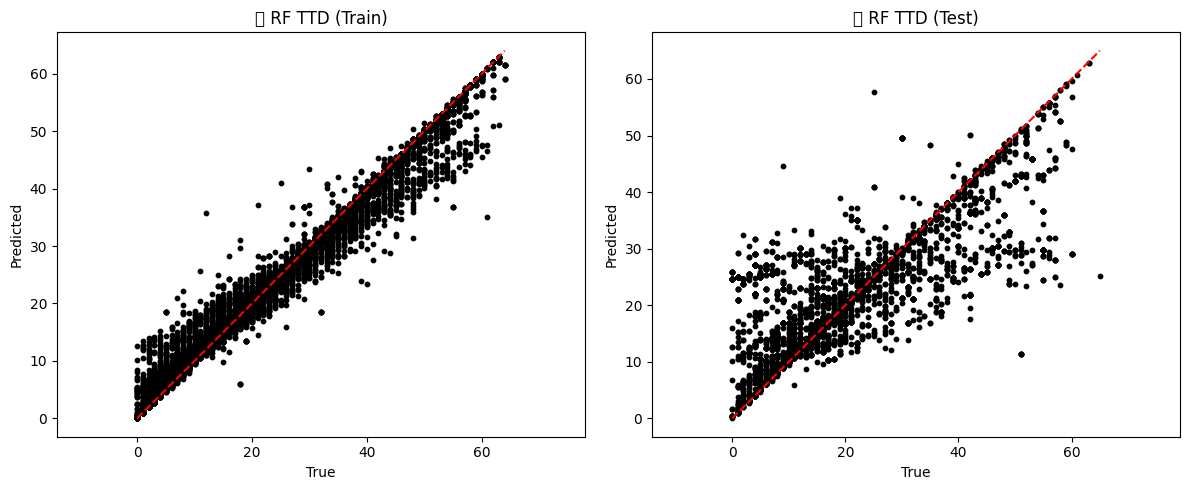

/tmp/ipython-input-18-2622986954.py:102: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


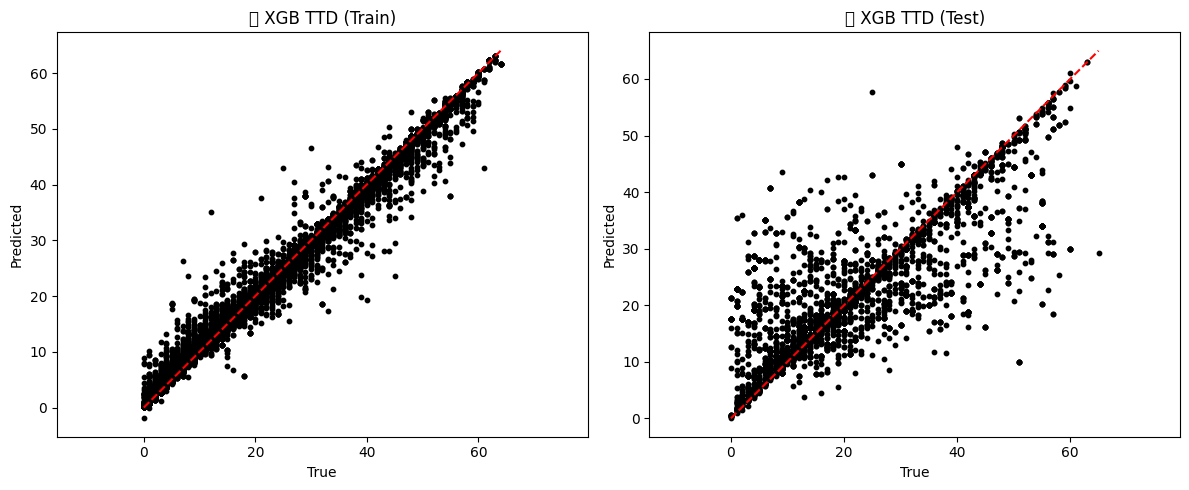

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


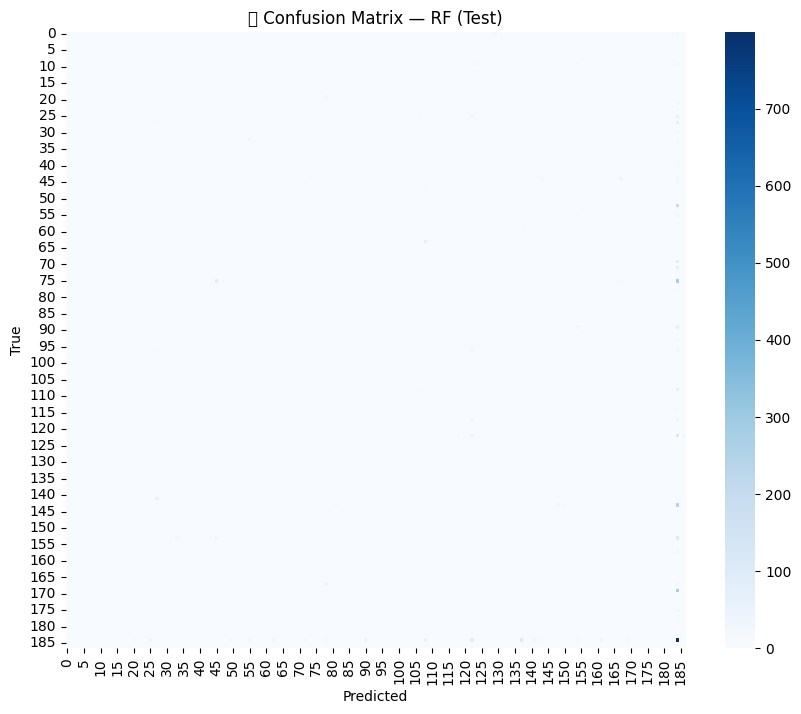

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259], got [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  42  43  44  45  46  47  48  49  50  51  52  54  55  56
  58  59  60  61  62  64  65  66  67  68  69  70  71  72  73  76  78  79
  80  81  82  84  85  86  87  88  89  90  91  92  94  95  96  97  98  99
 100 102 103 104 106 107 108 109 110 111 112 113 114 115 116 117 118 120
 121 122 124 125 126 127 128 129 130 131 132 133 134 135 136 137 139 141
 142 144 145 146 147 148 149 150 151 153 154 155 156 157 158 159 160 161
 162 164 165 168 169 170 172 173 174 176 177 178 179 180 181 182 183 184
 185 187 189 190 191 192 193 194 196 197 198 199 200 201 202 203 204 205
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 223 224 225
 226 227 228 229 230 231 232 233 235 236 238 239 240 241 242 243 244 245
 246 248 250 251 252 254 255 256 257 258 259 260 261 262 263 264 265 266
 267 268 269 270 272 273 275 276 277 278 279 281 283 284 286 287 288 289
 290 291 292 293 294 295 296 297]

In [ ]:
# --- 📦 IMPORTS ---
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# --- 📂 LOAD SAVED BEST PARAMS ---
best_rf = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_rf.pkl")
best_xgb = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl")

# --- 🧮 CLEAN FEATURE SETS ---
X_clean = X[:, :4098]  # image + age + gender
y_ttd = y.copy()
groups = df_images["imdb_id"].values

# --- 🧬 CAUSE OF DEATH LABELS ---
le = LabelEncoder()
y_cod = le.fit_transform(df_images["cause_of_death"].fillna("unknown").values)

# --- 🔀 STRATIFIED GROUP SPLIT: TIME TO DEATH (REGRESSION) ---
n_bins = 10
bins_ttd = pd.qcut(y_ttd, q=n_bins, labels=False, duplicates='drop')
sgkf_ttd = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in sgkf_ttd.split(X_clean, bins_ttd, groups):
    break  # use first split

X_ttd_train, X_ttd_test = X_clean[train_idx], X_clean[test_idx]
y_ttd_train, y_ttd_test = y_ttd[train_idx], y_ttd[test_idx]

# --- 🔀 STRATIFIED GROUP SPLIT: CAUSE OF DEATH (CLASSIFICATION) ---
bins_cod = y_cod.copy()  # already class labels
sgkf_cod = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for cod_train_idx, cod_test_idx in sgkf_cod.split(X_clean, bins_cod, groups):
    break

X_cod_train, X_cod_test = X_clean[cod_train_idx], X_clean[cod_test_idx]
y_cod_train, y_cod_test = y_cod[cod_train_idx], y_cod[cod_test_idx]

# --- 🤖 BUILD MODELS WITH BEST PARAMS ---
# === CLASSIFICATION MODELS ===
rf_clf_params = best_rf.get_params().copy()
xgb_clf_params = best_xgb.get_params().copy()

# Fix RF if using regression criterion
if rf_clf_params.get("criterion") == "squared_error":
    rf_clf_params["criterion"] = "gini"
for k in ["n_jobs", "random_state", "eval_metric"]:
    rf_clf_params.pop(k, None)
    xgb_clf_params.pop(k, None)

# 🧽 Prevent duplicate keys
xgb_clf_params.pop("objective", None)
xgb_clf_params.pop("num_class", None)

n_classes = len(np.unique(y_cod))
clf_rf = RandomForestClassifier(**rf_clf_params, n_jobs=-1, random_state=42)
clf_xgb = XGBClassifier(**xgb_clf_params, n_jobs=-1, use_label_encoder=False,
                        eval_metric='mlogloss', objective='multi:softprob',
                        num_class=n_classes, random_state=42)


# === REGRESSION MODELS ===
rf_reg_params = best_rf.get_params().copy()
xgb_reg_params = best_xgb.get_params().copy()
for k in ["n_jobs", "random_state", "verbosity"]:
    rf_reg_params.pop(k, None)
    xgb_reg_params.pop(k, None)

reg_rf = RandomForestRegressor(**rf_reg_params, n_jobs=-1, random_state=42)
reg_xgb = XGBRegressor(**xgb_reg_params, n_jobs=-1, verbosity=0, random_state=42)

# --- 🧪 TRAINING & EVALUATION LOOP ---
results = []

# 🕒 TIME TO DEATH REGRESSION
for model, name in [(reg_rf, "RF"), (reg_xgb, "XGB")]:
    model.fit(X_ttd_train, y_ttd_train)
    pred_train = model.predict(X_ttd_train)
    pred_test = model.predict(X_ttd_test)
    results.extend([
        {"Task": "Time to Death", "Model": name, "Split": "Train", "R²": r2_score(y_ttd_train, pred_train), "MAE": mean_absolute_error(y_ttd_train, pred_train)},
        {"Task": "Time to Death", "Model": name, "Split": "Test", "R²": r2_score(y_ttd_test, pred_test), "MAE": mean_absolute_error(y_ttd_test, pred_test)}
    ])

    # --- 📉 SCATTER PLOT ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_ttd_train, pred_train, s=10, color='black')
    plt.plot([y_ttd_train.min(), y_ttd_train.max()], [y_ttd_train.min(), y_ttd_train.max()], 'r--')
    plt.title(f"🕒 {name} TTD (Train)"); plt.xlabel("True"); plt.ylabel("Predicted"); plt.axis("equal")

    plt.subplot(1, 2, 2)
    plt.scatter(y_ttd_test, pred_test, s=10, color='black')
    plt.plot([y_ttd_test.min(), y_ttd_test.max()], [y_ttd_test.min(), y_ttd_test.max()], 'r--')
    plt.title(f"🕒 {name} TTD (Test)"); plt.xlabel("True"); plt.ylabel("Predicted"); plt.axis("equal")
    plt.tight_layout(); plt.show()

# 🧬 CAUSE OF DEATH CLASSIFICATION
for model, name in [(clf_rf, "RF"), (clf_xgb, "XGB")]:
    model.fit(X_cod_train, y_cod_train)
    acc_train = accuracy_score(y_cod_train, model.predict(X_cod_train))
    acc_test = accuracy_score(y_cod_test, model.predict(X_cod_test))
    results.extend([
        {"Task": "Cause of Death", "Model": name, "Split": "Train", "Accuracy": acc_train},
        {"Task": "Cause of Death", "Model": name, "Split": "Test", "Accuracy": acc_test}
    ])

    # --- 📊 CONFUSION MATRIX ---
    y_pred_test = model.predict(X_cod_test)
    cm = confusion_matrix(y_cod_test, y_pred_test)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues", norm=None)
    plt.title(f"🧬 Confusion Matrix — {name} (Test)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

# --- 📊 RESULTS TABLE ---
df_results = pd.DataFrame(results)
display(df_results)

# --- 📈 BAR PLOTS ---
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results[df_results["Task"] == "Time to Death"], x="Model", y="R²", hue="Split")
plt.title("🕒 Time to Death Regression R²")
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=df_results[df_results["Task"] == "Cause of Death"], x="Model", y="Accuracy", hue="Split")
plt.title("🧬 Cause of Death Classification Accuracy")
plt.ylim(0, 1)
plt.show()

# --- 🔬 FEATURE IMPORTANCE PLOTS ---
def plot_feature_importances(model, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-20:][::-1]
    plt.figure(figsize=(12, 5))
    plt.bar([f"F{i}" for i in indices], importances[indices])
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_feature_importances(reg_xgb, "XGBoost Top 20 Feature Importances (TTD)")
plot_feature_importances(reg_rf, "Random Forest Top 20 Feature Importances (TTD)")
plot_feature_importances(clf_xgb, "XGBoost Top 20 Feature Importances (COD)")
plot_feature_importances(clf_rf, "Random Forest Top 20 Feature Importances (COD)")


/tmp/ipython-input-19-2424920416.py:32: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


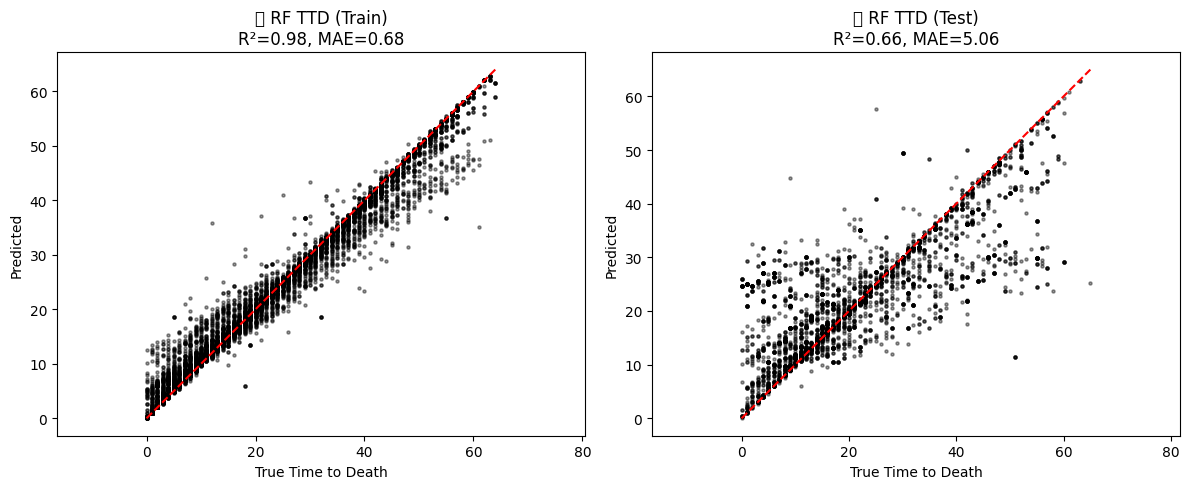

/tmp/ipython-input-19-2424920416.py:32: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


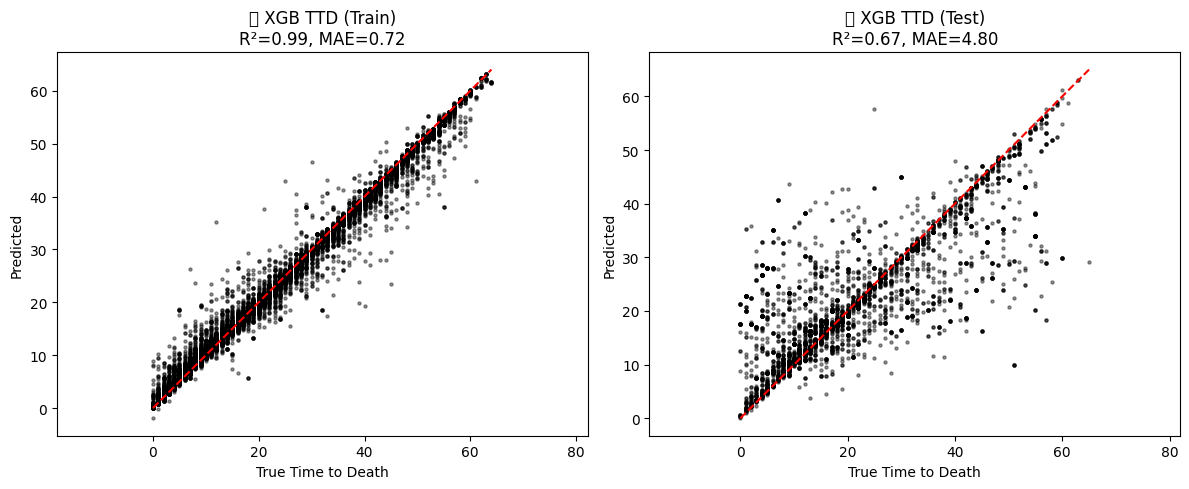

In [ ]:
# --- 📉 SCATTER PLOT: Time to Death with R² & MAE annotations ---
for model, name in [(reg_rf, "RF"), (reg_xgb, "XGB")]:
    pred_train = model.predict(X_ttd_train)
    pred_test = model.predict(X_ttd_test)
    r2_train = r2_score(y_ttd_train, pred_train)
    mae_train = mean_absolute_error(y_ttd_train, pred_train)
    r2_test = r2_score(y_ttd_test, pred_test)
    mae_test = mean_absolute_error(y_ttd_test, pred_test)

    plt.figure(figsize=(12, 5))

    # Train
    plt.subplot(1, 2, 1)
    plt.scatter(y_ttd_train, pred_train, s=5, alpha=0.4, color='black')
    plt.plot([y_ttd_train.min(), y_ttd_train.max()],
             [y_ttd_train.min(), y_ttd_train.max()], 'r--')
    plt.title(f"🕒 {name} TTD (Train)\nR²={r2_train:.2f}, MAE={mae_train:.2f}")
    plt.xlabel("True Time to Death")
    plt.ylabel("Predicted")
    plt.axis("equal")

    # Test
    plt.subplot(1, 2, 2)
    plt.scatter(y_ttd_test, pred_test, s=5, alpha=0.4, color='black')
    plt.plot([y_ttd_test.min(), y_ttd_test.max()],
             [y_ttd_test.min(), y_ttd_test.max()], 'r--')
    plt.title(f"🕒 {name} TTD (Test)\nR²={r2_test:.2f}, MAE={mae_test:.2f}")
    plt.xlabel("True Time to Death")
    plt.ylabel("Predicted")
    plt.axis("equal")

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-20-2210219808.py:26: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


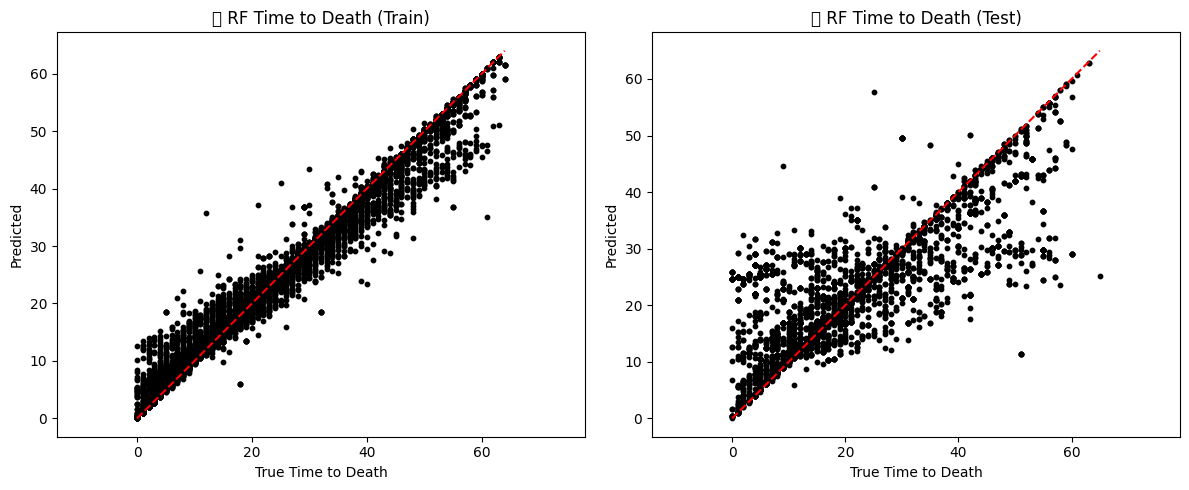

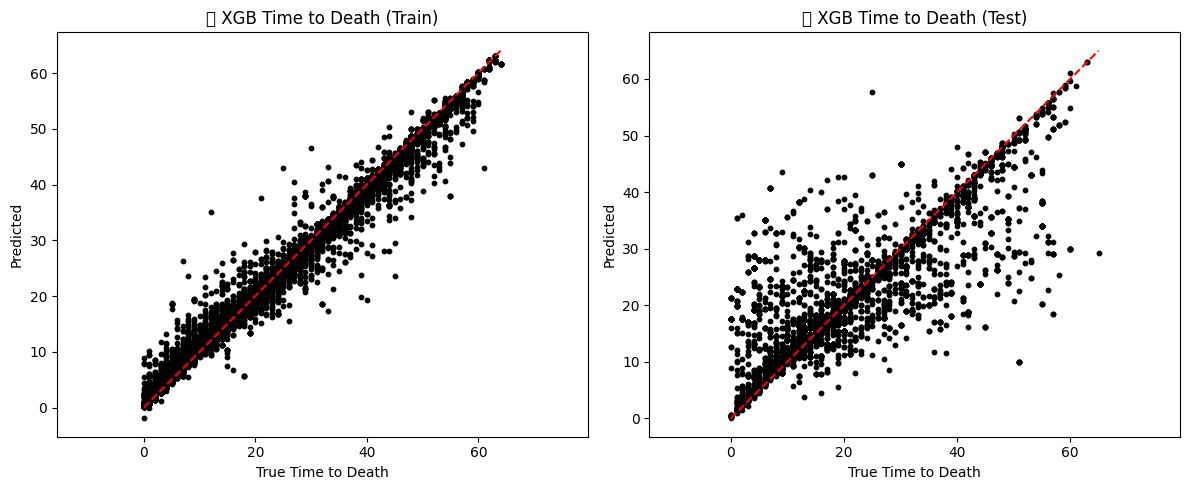

In [ ]:
# --- 📉 SCATTER PLOT: Time to Death (Regression) ---
for model, name in [(reg_rf, "RF"), (reg_xgb, "XGB")]:
    y_pred_train = model.predict(X_ttd_train)
    y_pred_test = model.predict(X_ttd_test)

    plt.figure(figsize=(12, 5))

    # Train
    plt.subplot(1, 2, 1)
    plt.scatter(y_ttd_train, y_pred_train, s=10, color='black')
    plt.plot([y_ttd_train.min(), y_ttd_train.max()], [y_ttd_train.min(), y_ttd_train.max()], 'r--')
    plt.xlabel("True Time to Death")
    plt.ylabel("Predicted")
    plt.title(f"🕒 {name} Time to Death (Train)")
    plt.axis("equal")

    # Test
    plt.subplot(1, 2, 2)
    plt.scatter(y_ttd_test, y_pred_test, s=10, color='black')
    plt.plot([y_ttd_test.min(), y_ttd_test.max()], [y_ttd_test.min(), y_ttd_test.max()], 'r--')
    plt.xlabel("True Time to Death")
    plt.ylabel("Predicted")
    plt.title(f"🕒 {name} Time to Death (Test)")
    plt.axis("equal")

    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

for model, name in [(clf_rf, "RF"), (clf_xgb, "XGB")]:
    y_pred_test = model.predict(X_cod_test)
    cm = confusion_matrix(y_cod_test, y_pred_test)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues", norm=None)
    plt.title(f"🧬 Confusion Matrix — {name} (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:1023: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


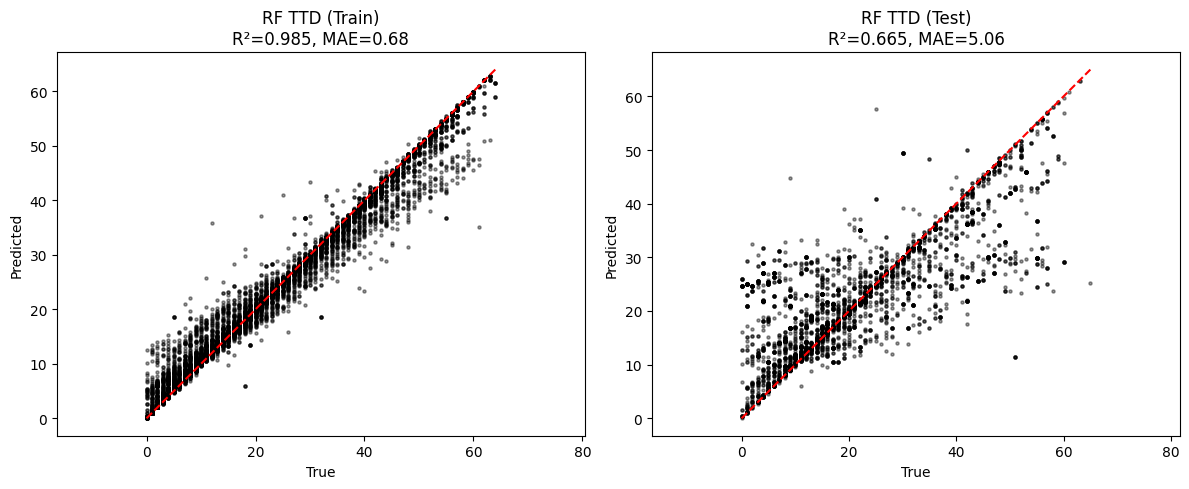

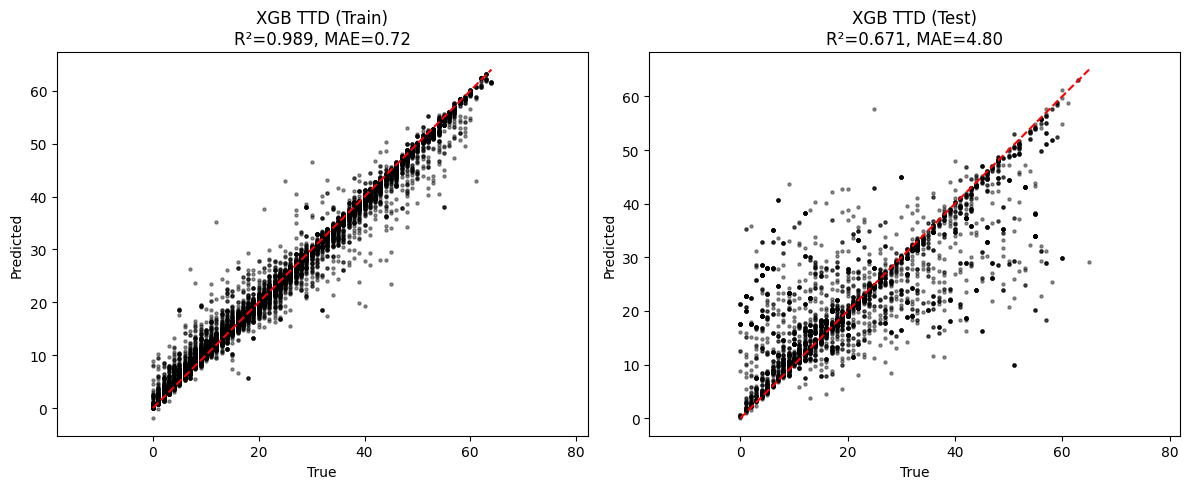

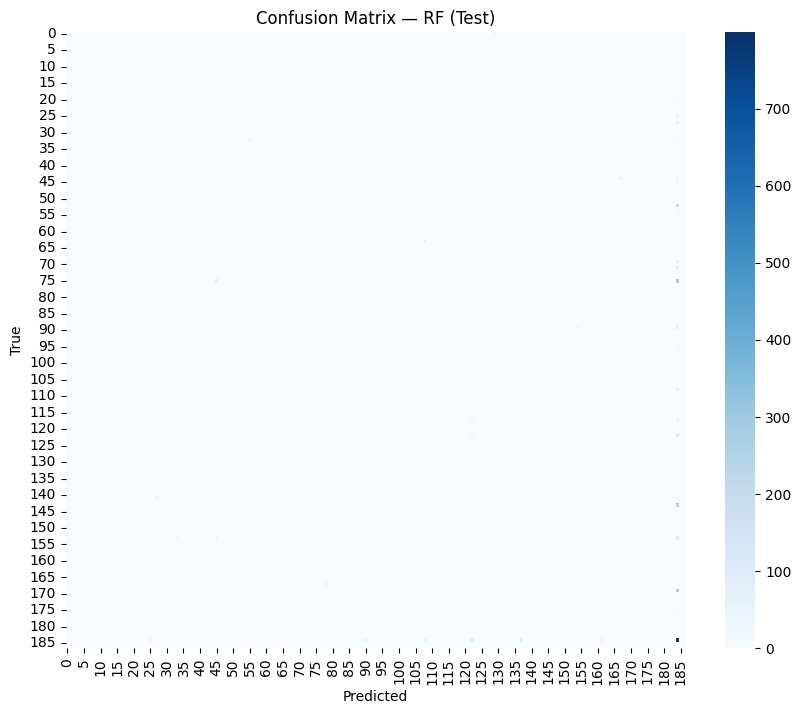

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259], got [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  42  43  44  45  46  47  48  49  50  51  52  54  55  56
  58  59  60  61  62  64  65  66  67  68  69  70  71  72  73  76  78  79
  80  81  82  84  85  86  87  88  89  90  91  92  94  95  96  97  98  99
 100 102 103 104 106 107 108 109 110 111 112 113 114 115 116 117 118 120
 121 122 124 125 126 127 128 129 130 131 132 133 134 135 136 137 139 141
 142 144 145 146 147 148 149 150 151 153 154 155 156 157 158 159 160 161
 162 164 165 168 169 170 172 173 174 176 177 178 179 180 181 182 183 184
 185 187 189 190 191 192 193 194 196 197 198 199 200 201 202 203 204 205
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 223 224 225
 226 227 228 229 230 231 232 233 235 236 238 239 240 241 242 243 244 245
 246 248 250 251 252 254 255 256 257 258 259 260 261 262 263 264 265 266
 267 268 269 270 272 273 275 276 277 278 279 281 283 284 286 287 288 289
 290 291 292 293 294 295 296 297]

In [ ]:
# --- 📦 IMPORTS ---
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# --- 📂 LOAD SAVED BEST PARAMS ---
best_rf = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_rf.pkl")
best_xgb = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl")

# --- 🧮 CLEAN FEATURE SETS ---
X_clean = X[:, :4098]  # image + age + gender
y_ttd = y.copy()
groups = df_images["imdb_id"].values

# --- 🧬 CAUSE OF DEATH LABELS ---
le = LabelEncoder()
y_cod = le.fit_transform(df_images["cause_of_death"].fillna("unknown").values)

# --- 🔀 STRATIFIED GROUP SPLIT: TIME TO DEATH (REGRESSION) ---
n_bins = 10
bins_ttd = pd.qcut(y_ttd, q=n_bins, labels=False, duplicates='drop')
sgkf_ttd = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in sgkf_ttd.split(X_clean, bins_ttd, groups):
    break

X_ttd_train, X_ttd_test = X_clean[train_idx], X_clean[test_idx]
y_ttd_train, y_ttd_test = y_ttd[train_idx], y_ttd[test_idx]

# --- 🔀 STRATIFIED GROUP SPLIT: CAUSE OF DEATH (CLASSIFICATION) ---
bins_cod = y_cod.copy()
sgkf_cod = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for cod_train_idx, cod_test_idx in sgkf_cod.split(X_clean, bins_cod, groups):
    break

X_cod_train, X_cod_test = X_clean[cod_train_idx], X_clean[cod_test_idx]
y_cod_train, y_cod_test = y_cod[cod_train_idx], y_cod[cod_test_idx]

# --- 🤖 BUILD MODELS WITH BEST PARAMS ---
# === CLASSIFICATION MODELS ===
rf_clf_params = best_rf.get_params().copy()
xgb_clf_params = best_xgb.get_params().copy()
rf_clf_params["criterion"] = "gini" if rf_clf_params.get("criterion") == "squared_error" else rf_clf_params["criterion"]
for k in ["n_jobs", "random_state", "eval_metric", "objective", "num_class"]:
    rf_clf_params.pop(k, None)
    xgb_clf_params.pop(k, None)

n_classes = len(np.unique(y_cod))
clf_rf = RandomForestClassifier(**rf_clf_params, n_jobs=-1, random_state=42)
clf_xgb = XGBClassifier(**xgb_clf_params, n_jobs=-1, use_label_encoder=False,
                        eval_metric='mlogloss', objective='multi:softprob',
                        num_class=n_classes, random_state=42)

# === REGRESSION MODELS ===
rf_reg_params = best_rf.get_params().copy()
xgb_reg_params = best_xgb.get_params().copy()
for k in ["n_jobs", "random_state", "verbosity"]:
    rf_reg_params.pop(k, None)
    xgb_reg_params.pop(k, None)

reg_rf = RandomForestRegressor(**rf_reg_params, n_jobs=-1, random_state=42)
reg_xgb = XGBRegressor(**xgb_reg_params, n_jobs=-1, verbosity=0, random_state=42)

# --- 🧪 TRAINING & EVALUATION LOOP ---
results = []

# 🕒 TIME TO DEATH REGRESSION
for model, name in [(reg_rf, "RF"), (reg_xgb, "XGB")]:
    model.fit(X_ttd_train, y_ttd_train)
    pred_train = model.predict(X_ttd_train)
    pred_test = model.predict(X_ttd_test)

    r2_train, mae_train = r2_score(y_ttd_train, pred_train), mean_absolute_error(y_ttd_train, pred_train)
    r2_test, mae_test = r2_score(y_ttd_test, pred_test), mean_absolute_error(y_ttd_test, pred_test)

    results.extend([
        {"Task": "Time to Death", "Model": name, "Split": "Train", "R²": r2_train, "MAE": mae_train},
        {"Task": "Time to Death", "Model": name, "Split": "Test", "R²": r2_test, "MAE": mae_test}
    ])

    # --- 📉 SCATTER PLOT ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_ttd_train, pred_train, s=5, alpha=0.4, color='black')
    plt.plot([y_ttd_train.min(), y_ttd_train.max()], [y_ttd_train.min(), y_ttd_train.max()], 'r--')
    plt.title(f"{name} TTD (Train)\nR²={r2_train:.3f}, MAE={mae_train:.2f}")
    plt.xlabel("True"); plt.ylabel("Predicted"); plt.axis("equal")

    plt.subplot(1, 2, 2)
    plt.scatter(y_ttd_test, pred_test, s=5, alpha=0.4, color='black')
    plt.plot([y_ttd_test.min(), y_ttd_test.max()], [y_ttd_test.min(), y_ttd_test.max()], 'r--')
    plt.title(f"{name} TTD (Test)\nR²={r2_test:.3f}, MAE={mae_test:.2f}")
    plt.xlabel("True"); plt.ylabel("Predicted"); plt.axis("equal")
    plt.tight_layout(); plt.show()

# 🧬 CAUSE OF DEATH CLASSIFICATION
for model, name in [(clf_rf, "RF"), (clf_xgb, "XGB")]:
    model.fit(X_cod_train, y_cod_train)
    acc_train = accuracy_score(y_cod_train, model.predict(X_cod_train))
    acc_test = accuracy_score(y_cod_test, model.predict(X_cod_test))
    results.extend([
        {"Task": "Cause of Death", "Model": name, "Split": "Train", "Accuracy": acc_train},
        {"Task": "Cause of Death", "Model": name, "Split": "Test", "Accuracy": acc_test}
    ])

    # --- 📊 CONFUSION MATRIX ---
    y_pred_test = model.predict(X_cod_test)
    cm = confusion_matrix(y_cod_test, y_pred_test)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues", norm=None)
    plt.title(f"Confusion Matrix — {name} (Test)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

# --- 📊 RESULTS TABLE ---
df_results = pd.DataFrame(results)
display(df_results)

# --- 📈 BAR PLOTS ---
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results[df_results["Task"] == "Time to Death"], x="Model", y="R²", hue="Split")
plt.title("Time to Death Regression R²"); plt.ylim(0, 1); plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=df_results[df_results["Task"] == "Cause of Death"], x="Model", y="Accuracy", hue="Split")
plt.title("Cause of Death Classification Accuracy"); plt.ylim(0, 1); plt.show()

# --- 🔬 FEATURE IMPORTANCE PLOTS ---
def plot_feature_importances(model, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-20:][::-1]
    plt.figure(figsize=(12, 5))
    plt.bar([f"F{i}" for i in indices], importances[indices])
    plt.title(title); plt.xticks(rotation=90); plt.show()

plot_feature_importances(reg_xgb, "XGBoost Top 20 Feature Importances (TTD)")
plot_feature_importances(reg_rf, "Random Forest Top 20 Feature Importances (TTD)")
plot_feature_importances(clf_xgb, "XGBoost Top 20 Feature Importances (COD)")
plot_feature_importances(clf_rf, "Random Forest Top 20 Feature Importances (COD)")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:1023: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


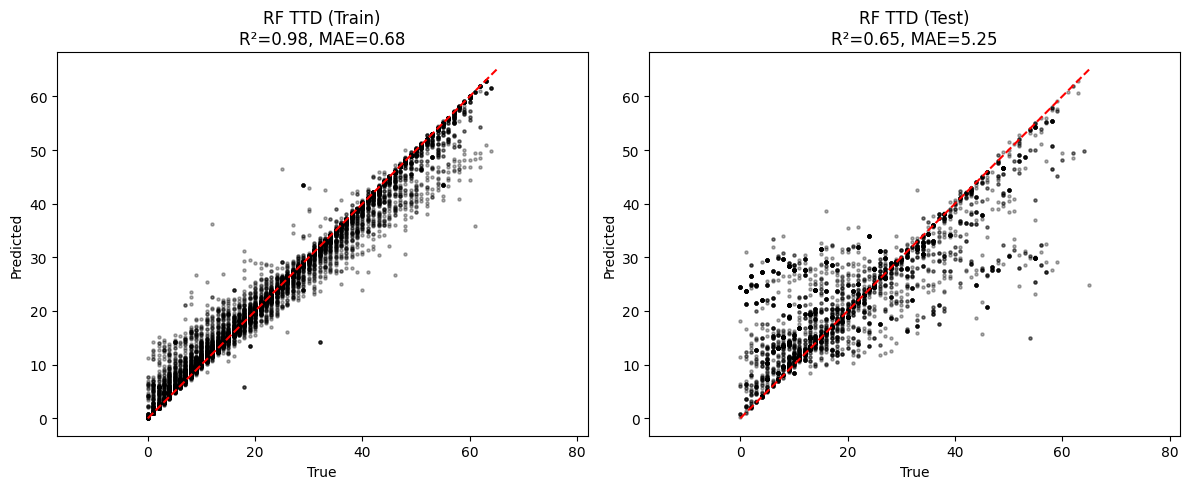

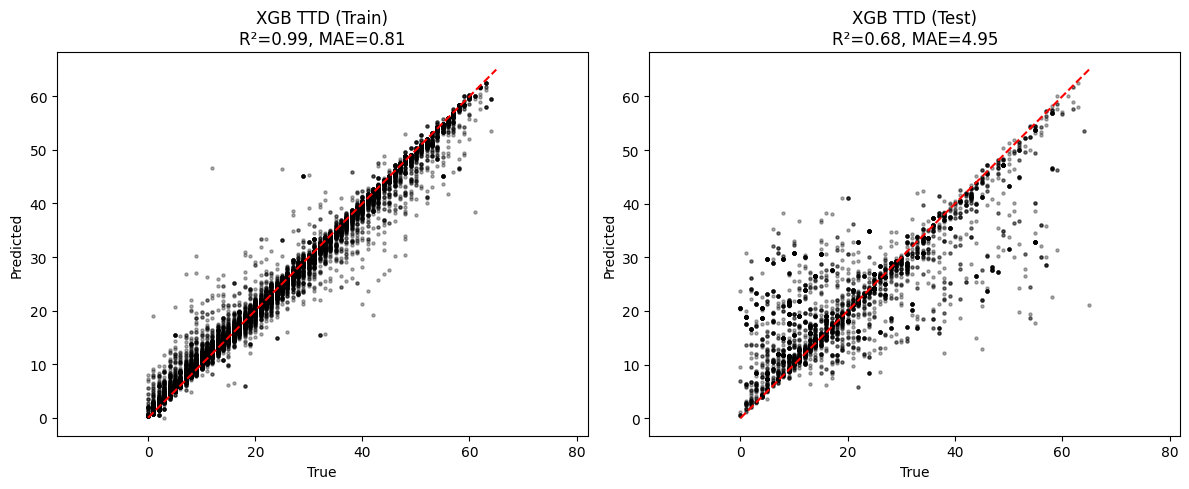

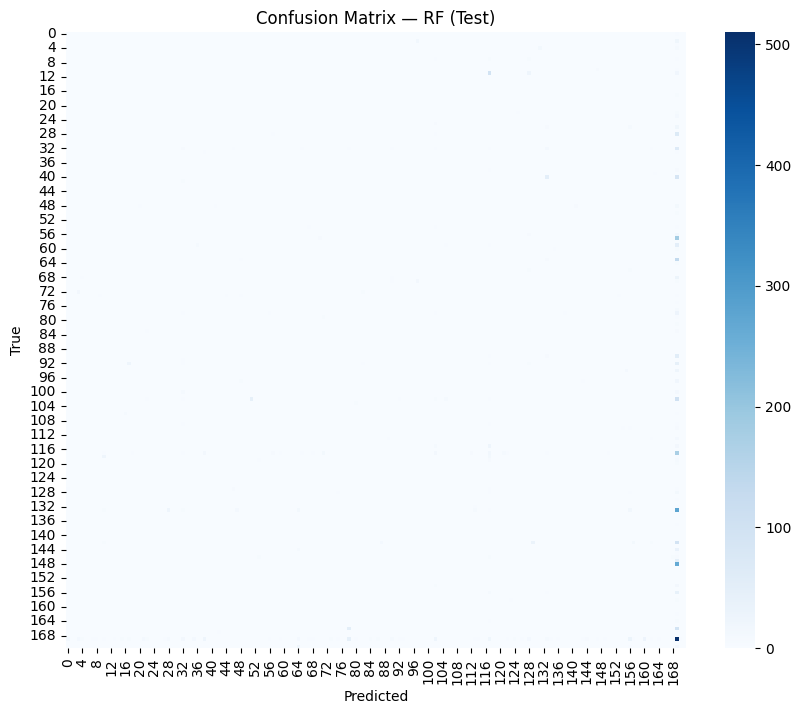

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236], got [  0   1   3   4   6   7   8   9  10  11  13  15  16  17  18  19  20  22
  23  24  25  27  28  29  30  31  32  33  34  35  36  38  39  41  42  44
  45  46  47  48  49  50  53  55  56  57  58  61  63  64  65  67  68  69
  70  71  72  73  74  75  76  77  78  80  81  83  84  85  86  87  89  90
  91  93  95  97  98 100 101 102 103 104 105 107 108 109 110 111 112 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 132 133
 135 137 138 141 142 144 145 146 148 149 150 151 152 154 155 156 157 158
 160 161 162 163 164 165 166 168 169 170 171 173 174 177 178 179 180 181
 182 183 184 187 188 189 190 192 193 195 196 197 198 199 203 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 223 224 225 227
 229 230 231 232 233 234 235 238 239 240 241 242 244 245 246 247 248 249
 250 251 252 255 256 258 260 261 262 263 264 265 266 268 269 270 271 273
 274 275 276 277 278 280 281 282 283 285 286 287 288 289 290 291 292 293
 295 296 297]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from collections import Counter

# === 🧮 Assume variables X, y, df_images are already loaded ===
# Example:
# X = np.load("X.npy")
# y = np.load("y_ttd.npy")
# df_images = pd.read_csv("metadata.csv")

# --- 🧮 CLEAN FEATURE SETS ---
X_clean = X[:, :4098]  # image + age + gender
y_ttd = y.copy()
groups = df_images["imdb_id"].values
cause_raw = df_images["cause_of_death"].fillna("unknown").values

# --- 🧬 CAUSE OF DEATH LABELS ---
le = LabelEncoder()
y_cod = le.fit_transform(cause_raw)

# --- ✅ FILTER OUT RARE CLASSES (<2 SAMPLES) ---
cod_counts = Counter(y_cod)
valid_classes = {cls for cls, count in cod_counts.items() if count >= 2}
mask = np.isin(y_cod, list(valid_classes))
X_clean, y_ttd, y_cod, groups = X_clean[mask], y_ttd[mask], y_cod[mask], groups[mask]

# --- 🔀 STRATIFIED GROUP SPLIT: TIME TO DEATH ---
n_bins = 10
bins_ttd = pd.qcut(y_ttd, q=n_bins, labels=False, duplicates='drop')
sgkf_ttd = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in sgkf_ttd.split(X_clean, bins_ttd, groups):
    break

X_ttd_train, X_ttd_test = X_clean[train_idx], X_clean[test_idx]
y_ttd_train, y_ttd_test = y_ttd[train_idx], y_ttd[test_idx]

# --- 🔀 STRATIFIED GROUP SPLIT: CAUSE OF DEATH ---
bins_cod = y_cod
sgkf_cod = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for cod_train_idx, cod_test_idx in sgkf_cod.split(X_clean, bins_cod, groups):
    break

X_cod_train, X_cod_test = X_clean[cod_train_idx], X_clean[cod_test_idx]
y_cod_train, y_cod_test = y_cod[cod_train_idx], y_cod[cod_test_idx]

# --- 📂 LOAD SAVED BEST PARAMS ---
best_rf = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_rf.pkl")
best_xgb = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl")

# === 🤖 BUILD MODELS ===
# Classification
rf_clf_params = best_rf.get_params().copy()
xgb_clf_params = best_xgb.get_params().copy()
if rf_clf_params.get("criterion") == "squared_error":
    rf_clf_params["criterion"] = "gini"
for k in ["n_jobs", "random_state", "eval_metric"]:
    rf_clf_params.pop(k, None)
    xgb_clf_params.pop(k, None)
xgb_clf_params.pop("objective", None)
xgb_clf_params.pop("num_class", None)
n_classes = len(np.unique(y_cod))

clf_rf = RandomForestClassifier(**rf_clf_params, n_jobs=-1, random_state=42)
clf_xgb = XGBClassifier(**xgb_clf_params, n_jobs=-1, use_label_encoder=False,
                        eval_metric='mlogloss', objective='multi:softprob',
                        num_class=n_classes, random_state=42)

# Regression
rf_reg_params = best_rf.get_params().copy()
xgb_reg_params = best_xgb.get_params().copy()
for k in ["n_jobs", "random_state", "verbosity"]:
    rf_reg_params.pop(k, None)
    xgb_reg_params.pop(k, None)
reg_rf = RandomForestRegressor(**rf_reg_params, n_jobs=-1, random_state=42)
reg_xgb = XGBRegressor(**xgb_reg_params, n_jobs=-1, verbosity=0, random_state=42)

# === 🧪 TRAIN + EVAL ===
results = []

# --- 🕒 TTD REGRESSION ---
for model, name in [(reg_rf, "RF"), (reg_xgb, "XGB")]:
    model.fit(X_ttd_train, y_ttd_train)
    pred_train = model.predict(X_ttd_train)
    pred_test = model.predict(X_ttd_test)
    r2_train = r2_score(y_ttd_train, pred_train)
    r2_test = r2_score(y_ttd_test, pred_test)
    mae_train = mean_absolute_error(y_ttd_train, pred_train)
    mae_test = mean_absolute_error(y_ttd_test, pred_test)

    results.extend([
        {"Task": "Time to Death", "Model": name, "Split": "Train", "R²": r2_train, "MAE": mae_train},
        {"Task": "Time to Death", "Model": name, "Split": "Test", "R²": r2_test, "MAE": mae_test}
    ])

    # PLOT
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_ttd_train, pred_train, s=5, color='black', alpha=0.3)
    plt.plot([y_ttd.min(), y_ttd.max()], [y_ttd.min(), y_ttd.max()], 'r--')
    plt.xlabel("True"); plt.ylabel("Predicted"); plt.title(f"{name} TTD (Train)\nR²={r2_train:.2f}, MAE={mae_train:.2f}")
    plt.axis("equal")

    plt.subplot(1, 2, 2)
    plt.scatter(y_ttd_test, pred_test, s=5, color='black', alpha=0.3)
    plt.plot([y_ttd.min(), y_ttd.max()], [y_ttd.min(), y_ttd.max()], 'r--')
    plt.xlabel("True"); plt.ylabel("Predicted"); plt.title(f"{name} TTD (Test)\nR²={r2_test:.2f}, MAE={mae_test:.2f}")
    plt.axis("equal")
    plt.tight_layout(); plt.show()

# --- 🧬 CAUSE OF DEATH ---
for model, name in [(clf_rf, "RF"), (clf_xgb, "XGB")]:
    model.fit(X_cod_train, y_cod_train)
    acc_train = accuracy_score(y_cod_train, model.predict(X_cod_train))
    acc_test = accuracy_score(y_cod_test, model.predict(X_cod_test))
    results.extend([
        {"Task": "Cause of Death", "Model": name, "Split": "Train", "Accuracy": acc_train},
        {"Task": "Cause of Death", "Model": name, "Split": "Test", "Accuracy": acc_test}
    ])
    # Confusion Matrix
    y_pred_test = model.predict(X_cod_test)
    cm = confusion_matrix(y_cod_test, y_pred_test)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues")
    plt.title(f"Confusion Matrix — {name} (Test)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

# --- 📊 RESULTS ---
df_results = pd.DataFrame(results)
display(df_results)

# --- 📈 BAR PLOTS ---
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results[df_results["Task"] == "Time to Death"], x="Model", y="R²", hue="Split")
plt.title("Time to Death Regression R²"); plt.ylim(0, 1); plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=df_results[df_results["Task"] == "Cause of Death"], x="Model", y="Accuracy", hue="Split")
plt.title("Cause of Death Classification Accuracy"); plt.ylim(0, 1); plt.show()

# --- 🔬 FEATURE IMPORTANCE ---
def plot_feature_importances(model, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-20:][::-1]
    plt.figure(figsize=(12, 5))
    plt.bar([f"F{i}" for i in indices], importances[indices])
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_feature_importances(reg_xgb, "XGB Feature Importances (TTD)")
plot_feature_importances(reg_rf, "RF Feature Importances (TTD)")
plot_feature_importances(clf_xgb, "XGB Feature Importances (COD)")
plot_feature_importances(clf_rf, "RF Feature Importances (COD)")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:1023: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


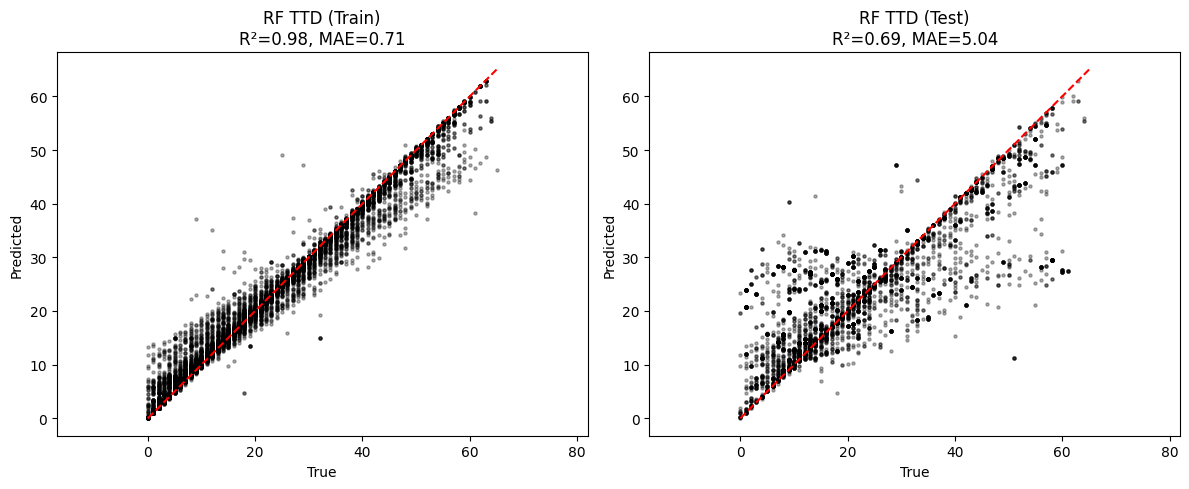

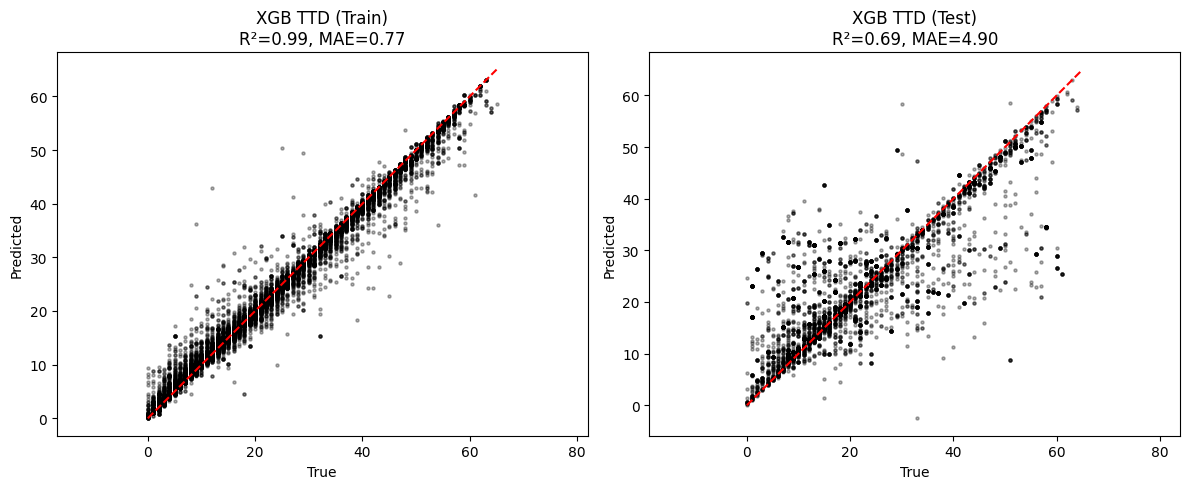

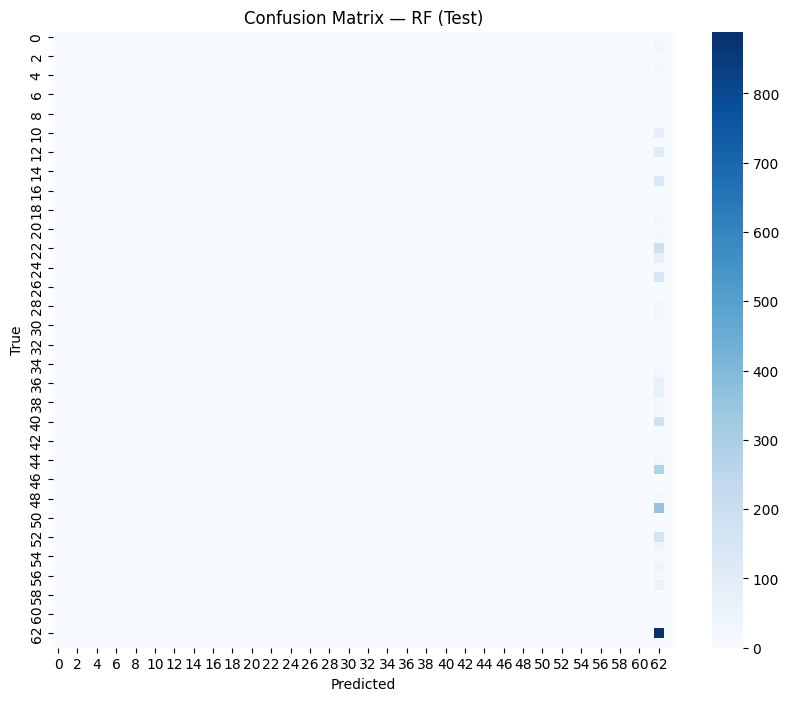

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [03:10:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


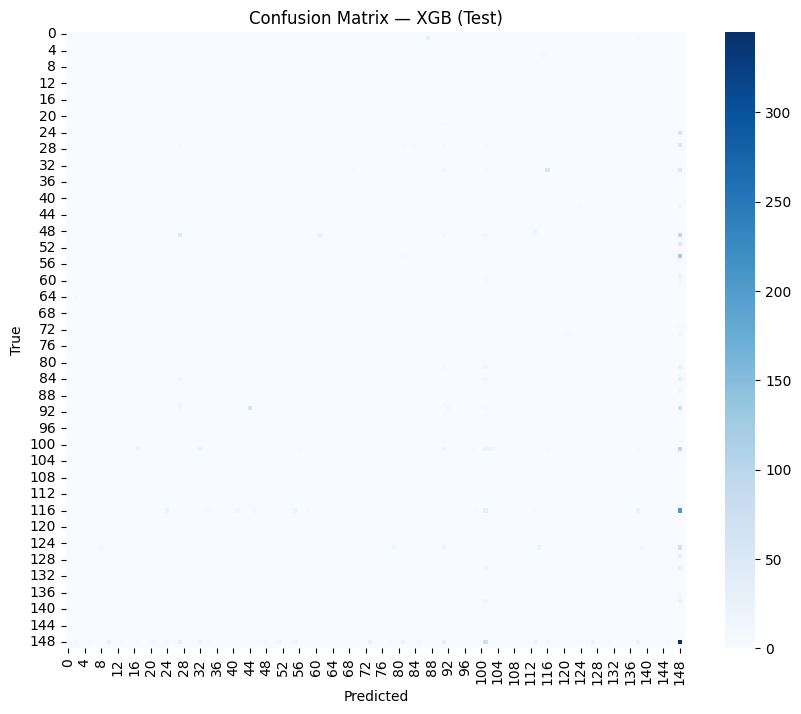

,Task,Model,Split,R²,MAE,Accuracy
0,Time to Death,RF,Train,0.983609,0.706504,NaN
1,Time to Death,RF,Test,0.693325,5.042268,NaN
2,Time to Death,XGB,Train,0.987121,0.766075,NaN
3,Time to Death,XGB,Test,0.694102,4.900134,NaN
4,Cause of Death,RF,Train,NaN,NaN,0.366004
5,Cause of Death,RF,Test,NaN,NaN,0.260450
6,Cause of Death,XGB,Train,NaN,NaN,0.819112
7,Cause of Death,XGB,Test,NaN,NaN,0.111956


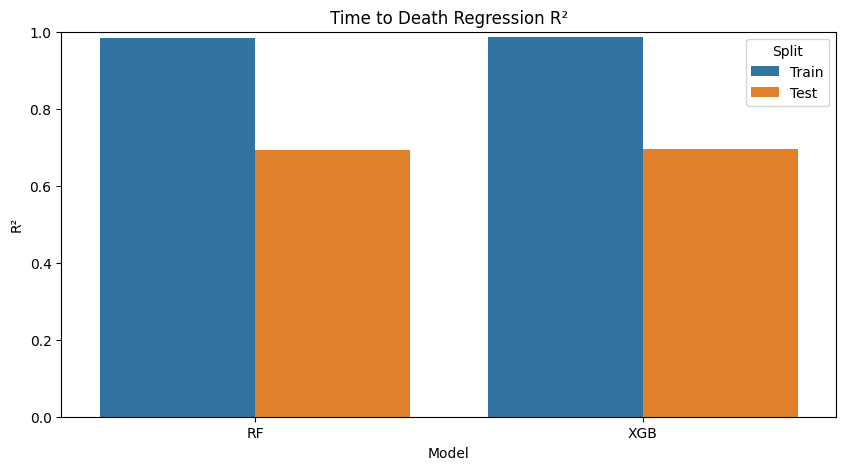

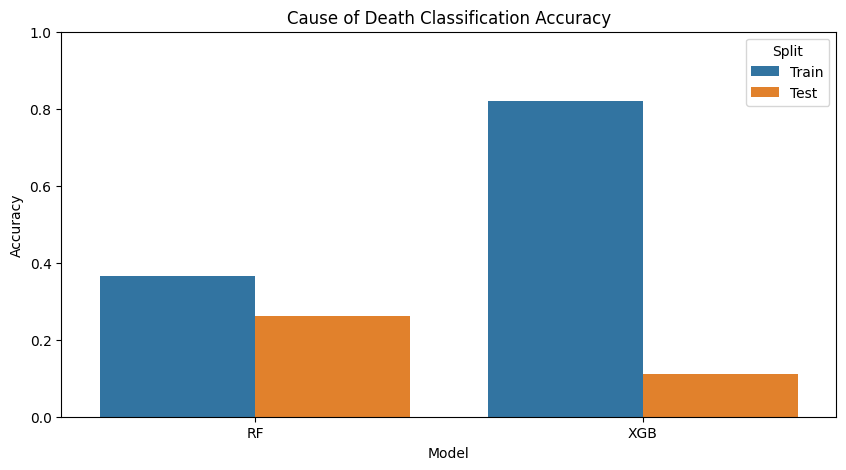

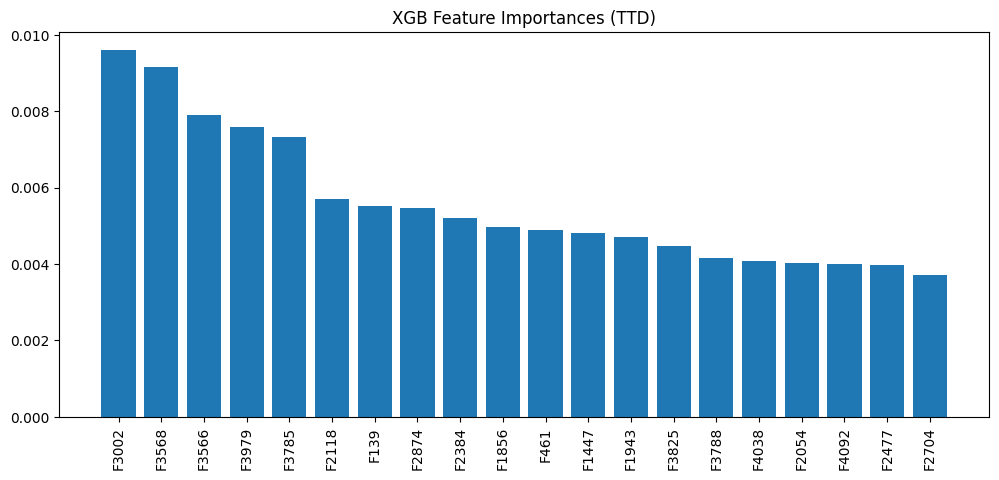

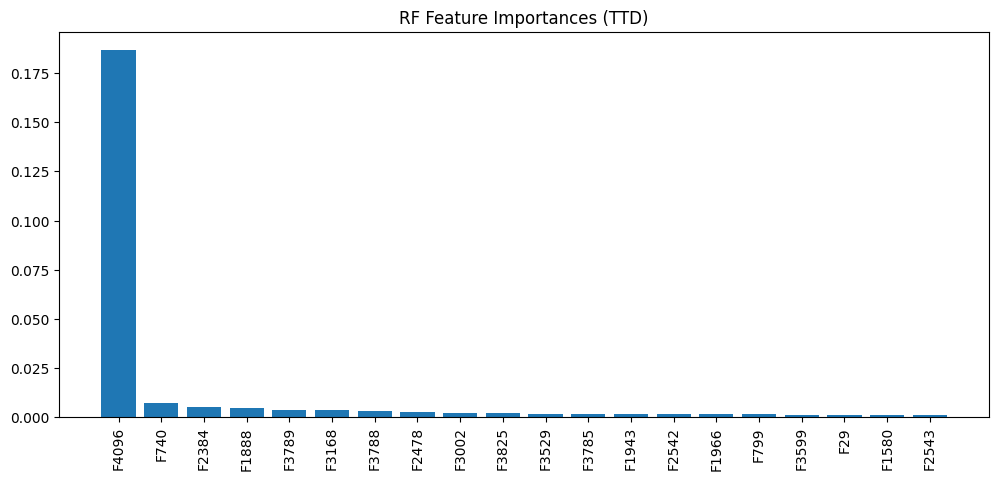

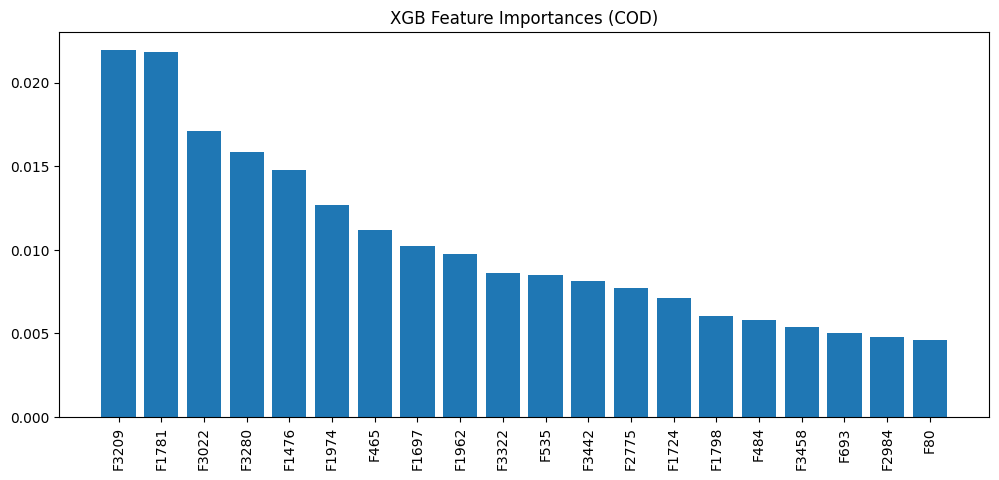

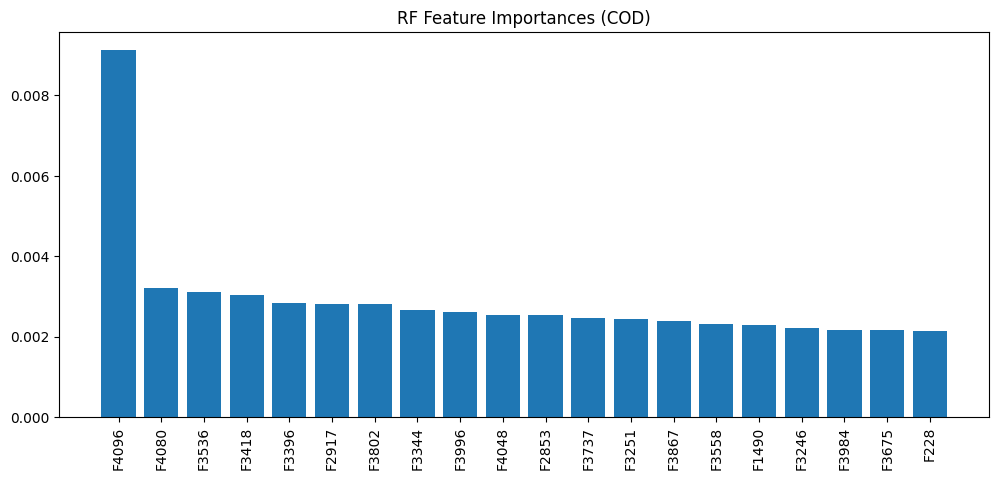

In [ ]:
# 📦 LIBRARIES
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import joblib
import copy



# === 🧮 CLEAN FEATURES ===
X_clean = X[:, :4098]
y_ttd = y.copy()
groups = df_images["imdb_id"].values
cause_raw = df_images["cause_of_death"].fillna("unknown").values
y_cod = LabelEncoder().fit_transform(cause_raw)

# === 🔀 TIME-TO-DEATH SPLIT FIRST ===
n_bins = 10
bins_ttd = pd.qcut(y_ttd, q=n_bins, labels=False, duplicates='drop')
sgkf_ttd = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in sgkf_ttd.split(X_clean, bins_ttd, groups):
    break
X_ttd_train, X_ttd_test = X_clean[train_idx], X_clean[test_idx]
y_ttd_train, y_ttd_test = y_ttd[train_idx], y_ttd[test_idx]

# === 🧬 CAUSE OF DEATH LABELS ===
cod_counts = Counter(y_cod)
valid_classes = {cls for cls, count in cod_counts.items() if count >= 2}
mask = np.isin(y_cod, list(valid_classes))
X_clean, y_cod, groups = X_clean[mask], y_cod[mask], groups[mask]

# === 🔄 Re-split for COD with valid classes ===
bins_cod = y_cod
sgkf_cod = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for cod_train_idx, cod_test_idx in sgkf_cod.split(X_clean, bins_cod, groups):
    break
X_cod_train, X_cod_test = X_clean[cod_train_idx], X_clean[cod_test_idx]
y_cod_train_raw, y_cod_test_raw = y_cod[cod_train_idx], y_cod[cod_test_idx]

# Fit encoder on training set only
le_cod_split = LabelEncoder()
y_cod_train = le_cod_split.fit_transform(y_cod_train_raw)

# Filter test set to only include labels seen in training set
seen_classes = set(le_cod_split.classes_)
mask_test = np.isin(y_cod_test_raw, list(seen_classes))
X_cod_test = X_cod_test[mask_test]
y_cod_test_raw = y_cod_test_raw[mask_test]
y_cod_test = le_cod_split.transform(y_cod_test_raw)

n_classes = len(le_cod_split.classes_)

# === 🧠 LOAD BEST MODELS FOR TTD ===
best_rf = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_rf.pkl")
best_xgb = joblib.load("/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl")

rf_reg_params = copy.deepcopy(best_rf.get_params())
xgb_reg_params = copy.deepcopy(best_xgb.get_params())
rf_reg_params.update({"n_jobs": -1, "random_state": 42})
xgb_reg_params.update({"n_jobs": -1, "random_state": 42, "verbosity": 0})

reg_rf = RandomForestRegressor(**rf_reg_params)
reg_xgb = XGBRegressor(**xgb_reg_params)

# === 🧠 CLASSIFIERS FOR COD ===
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
clf_xgb = XGBClassifier(n_estimators=100, max_depth=10, use_label_encoder=False,
                        eval_metric='mlogloss', objective='multi:softprob',
                        num_class=n_classes, n_jobs=-1, random_state=42)

results = []

# === 🔬 TIME TO DEATH REGRESSION ===
for model, name in [(reg_rf, "RF"), (reg_xgb, "XGB")]:
    model.fit(X_ttd_train, y_ttd_train)
    pred_train = model.predict(X_ttd_train)
    pred_test = model.predict(X_ttd_test)
    r2_train = r2_score(y_ttd_train, pred_train)
    r2_test = r2_score(y_ttd_test, pred_test)
    mae_train = mean_absolute_error(y_ttd_train, pred_train)
    mae_test = mean_absolute_error(y_ttd_test, pred_test)

    results.extend([
        {"Task": "Time to Death", "Model": name, "Split": "Train", "R²": r2_train, "MAE": mae_train},
        {"Task": "Time to Death", "Model": name, "Split": "Test", "R²": r2_test, "MAE": mae_test}
    ])

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_ttd_train, pred_train, s=5, color='black', alpha=0.3)
    plt.plot([y_ttd.min(), y_ttd.max()], [y_ttd.min(), y_ttd.max()], 'r--')
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.title(f"{name} TTD (Train)\nR²={r2_train:.2f}, MAE={mae_train:.2f}")
    plt.axis("equal")

    plt.subplot(1, 2, 2)
    plt.scatter(y_ttd_test, pred_test, s=5, color='black', alpha=0.3)
    plt.plot([y_ttd.min(), y_ttd.max()], [y_ttd.min(), y_ttd.max()], 'r--')
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.title(f"{name} TTD (Test)\nR²={r2_test:.2f}, MAE={mae_test:.2f}")
    plt.axis("equal")
    plt.tight_layout(); plt.show()

# === 💀 CAUSE OF DEATH CLASSIFICATION ===
for model, name in [(clf_rf, "RF"), (clf_xgb, "XGB")]:
    model.fit(X_cod_train, y_cod_train)
    acc_train = accuracy_score(y_cod_train, model.predict(X_cod_train))
    acc_test = accuracy_score(y_cod_test, model.predict(X_cod_test))
    results.extend([
        {"Task": "Cause of Death", "Model": name, "Split": "Train", "Accuracy": acc_train},
        {"Task": "Cause of Death", "Model": name, "Split": "Test", "Accuracy": acc_test}
    ])

    # Confusion matrix
    cm = confusion_matrix(y_cod_test, model.predict(X_cod_test))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues")
    plt.title(f"Confusion Matrix — {name} (Test)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

# === 📊 RESULTS ===
df_results = pd.DataFrame(results)
display(df_results)

# === 📈 METRIC PLOTS ===
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results[df_results["Task"] == "Time to Death"], x="Model", y="R²", hue="Split")
plt.title("Time to Death Regression R²"); plt.ylim(0, 1); plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=df_results[df_results["Task"] == "Cause of Death"], x="Model", y="Accuracy", hue="Split")
plt.title("Cause of Death Classification Accuracy"); plt.ylim(0, 1); plt.show()

# === 📌 FEATURE IMPORTANCE ===
def plot_feature_importances(model, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-20:][::-1]
    plt.figure(figsize=(12, 5))
    plt.bar([f"F{i}" for i in indices], importances[indices])
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_feature_importances(reg_xgb, "XGB Feature Importances (TTD)")
plot_feature_importances(reg_rf, "RF Feature Importances (TTD)")
plot_feature_importances(clf_xgb, "XGB Feature Importances (COD)")
plot_feature_importances(clf_rf, "RF Feature Importances (COD)")


final

best so far

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:1023: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


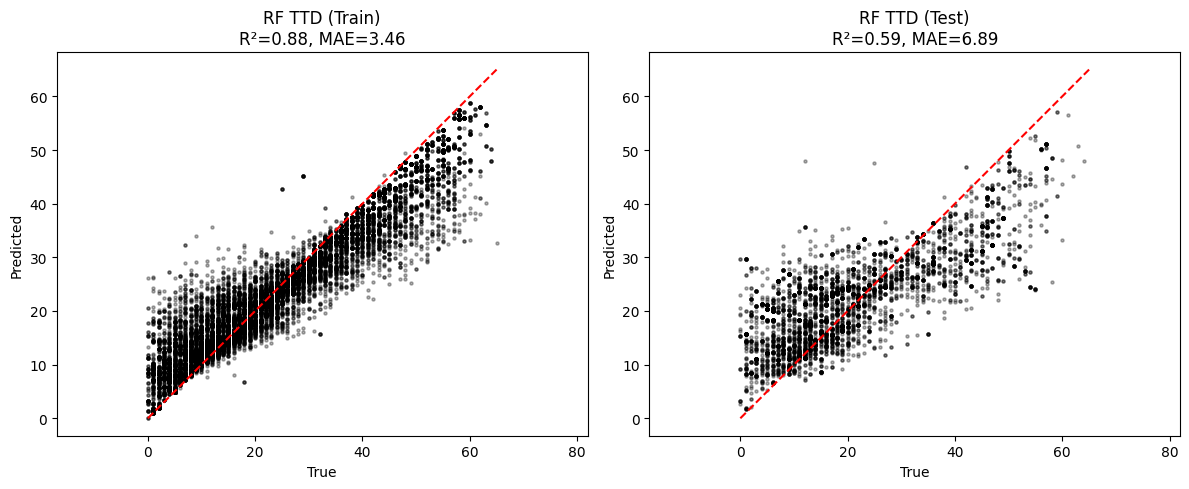

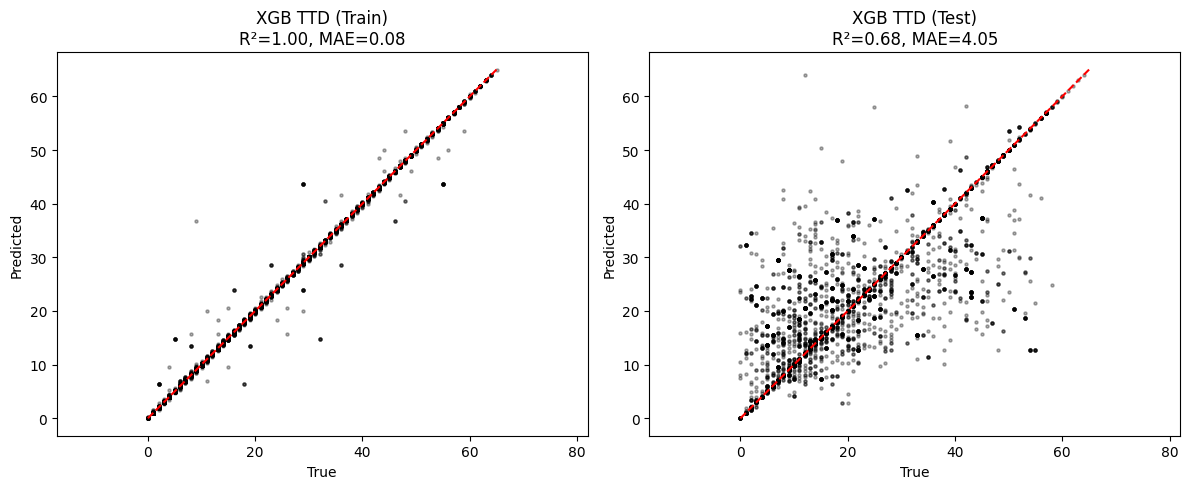

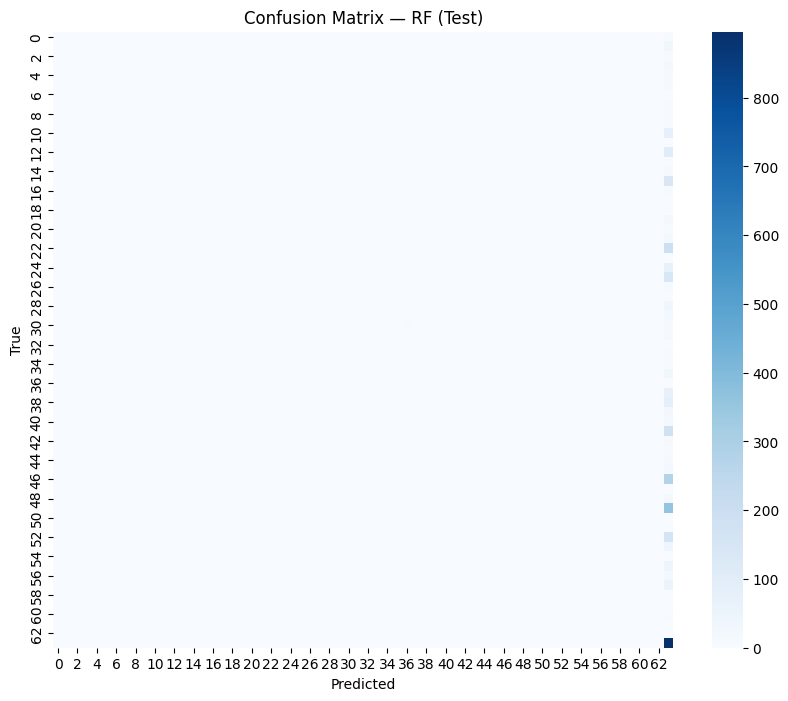

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:45:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# 📦 LIBRARIES
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# --- 🧮 CLEAN FEATURES ---
X_clean = X[:, :4098]
y_ttd = y.copy()
groups = df_images["imdb_id"].values
cause_raw = df_images["cause_of_death"].fillna("unknown").values
y_cod = LabelEncoder().fit_transform(cause_raw)

# --- 🔀 TIME-TO-DEATH SPLIT FIRST ---
n_bins = 10
bins_ttd = pd.qcut(y_ttd, q=n_bins, labels=False, duplicates='drop')
sgkf_ttd = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in sgkf_ttd.split(X_clean, bins_ttd, groups):
    break
X_ttd_train, X_ttd_test = X_clean[train_idx], X_clean[test_idx]
y_ttd_train, y_ttd_test = y_ttd[train_idx], y_ttd[test_idx]

# --- 🧬 CAUSE OF DEATH LABELS (after TTD split) ---
cod_counts = Counter(y_cod)
valid_classes = {cls for cls, count in cod_counts.items() if count >= 2}
mask = np.isin(y_cod, list(valid_classes))
X_clean, y_cod, groups = X_clean[mask], y_cod[mask], groups[mask]

# 🔄 Re-split for COD with valid classes
bins_cod = y_cod
sgkf_cod = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for cod_train_idx, cod_test_idx in sgkf_cod.split(X_clean, bins_cod, groups):
    break
X_cod_train, X_cod_test = X_clean[cod_train_idx], X_clean[cod_test_idx]
y_cod_train_raw, y_cod_test_raw = y_cod[cod_train_idx], y_cod[cod_test_idx]

# Fit encoder on training set only
le_cod_split = LabelEncoder()
y_cod_train = le_cod_split.fit_transform(y_cod_train_raw)

# Filter test set to only include labels seen in training set
seen_classes = set(le_cod_split.classes_)
mask_test = np.isin(y_cod_test_raw, list(seen_classes))
X_cod_test = X_cod_test[mask_test]
y_cod_test_raw = y_cod_test_raw[mask_test]
y_cod_test = le_cod_split.transform(y_cod_test_raw)

n_classes = len(le_cod_split.classes_)

# === 🧠 MODELS ===
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
clf_xgb = XGBClassifier(n_estimators=100, max_depth=10, use_label_encoder=False,
                        eval_metric='mlogloss', objective='multi:softprob',
                        num_class=n_classes, n_jobs=-1, random_state=42)
reg_rf = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
reg_xgb = XGBRegressor(n_estimators=100, max_depth=10, n_jobs=-1, verbosity=0, random_state=42)

results = []

# === 🔬 TIME TO DEATH REGRESSION ===
for model, name in [(reg_rf, "RF"), (reg_xgb, "XGB")]:
    model.fit(X_ttd_train, y_ttd_train)
    pred_train = model.predict(X_ttd_train)
    pred_test = model.predict(X_ttd_test)
    r2_train = r2_score(y_ttd_train, pred_train)
    r2_test = r2_score(y_ttd_test, pred_test)
    mae_train = mean_absolute_error(y_ttd_train, pred_train)
    mae_test = mean_absolute_error(y_ttd_test, pred_test)

    results.extend([
        {"Task": "Time to Death", "Model": name, "Split": "Train", "R²": r2_train, "MAE": mae_train},
        {"Task": "Time to Death", "Model": name, "Split": "Test", "R²": r2_test, "MAE": mae_test}
    ])

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_ttd_train, pred_train, s=5, color='black', alpha=0.3)
    plt.plot([y_ttd.min(), y_ttd.max()], [y_ttd.min(), y_ttd.max()], 'r--')
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.title(f"{name} TTD (Train)\nR²={r2_train:.2f}, MAE={mae_train:.2f}")
    plt.axis("equal")

    plt.subplot(1, 2, 2)
    plt.scatter(y_ttd_test, pred_test, s=5, color='black', alpha=0.3)
    plt.plot([y_ttd.min(), y_ttd.max()], [y_ttd.min(), y_ttd.max()], 'r--')
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.title(f"{name} TTD (Test)\nR²={r2_test:.2f}, MAE={mae_test:.2f}")
    plt.axis("equal")
    plt.tight_layout(); plt.show()

# === 💀 CAUSE OF DEATH CLASSIFICATION ===
for model, name in [(clf_rf, "RF"), (clf_xgb, "XGB")]:
    model.fit(X_cod_train, y_cod_train)
    acc_train = accuracy_score(y_cod_train, model.predict(X_cod_train))
    acc_test = accuracy_score(y_cod_test, model.predict(X_cod_test))
    results.extend([
        {"Task": "Cause of Death", "Model": name, "Split": "Train", "Accuracy": acc_train},
        {"Task": "Cause of Death", "Model": name, "Split": "Test", "Accuracy": acc_test}
    ])

    # Confusion matrix
    cm = confusion_matrix(y_cod_test, model.predict(X_cod_test))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues")
    plt.title(f"Confusion Matrix — {name} (Test)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

# === 📊 RESULTS ===
df_results = pd.DataFrame(results)
display(df_results)

# === 📈 METRIC PLOTS ===
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results[df_results["Task"] == "Time to Death"], x="Model", y="R²", hue="Split")
plt.title("Time to Death Regression R²"); plt.ylim(0, 1); plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=df_results[df_results["Task"] == "Cause of Death"], x="Model", y="Accuracy", hue="Split")
plt.title("Cause of Death Classification Accuracy"); plt.ylim(0, 1); plt.show()

# === 📌 FEATURE IMPORTANCE ===
def plot_feature_importances(model, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-20:][::-1]
    plt.figure(figsize=(12, 5))
    plt.bar([f"F{i}" for i in indices], importances[indices])
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_feature_importances(reg_xgb, "XGB Feature Importances (TTD)")
plot_feature_importances(reg_rf, "RF Feature Importances (TTD)")
plot_feature_importances(clf_xgb, "XGB Feature Importances (COD)")
plot_feature_importances(clf_rf, "RF Feature Importances (COD)")


no classification

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:1023: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


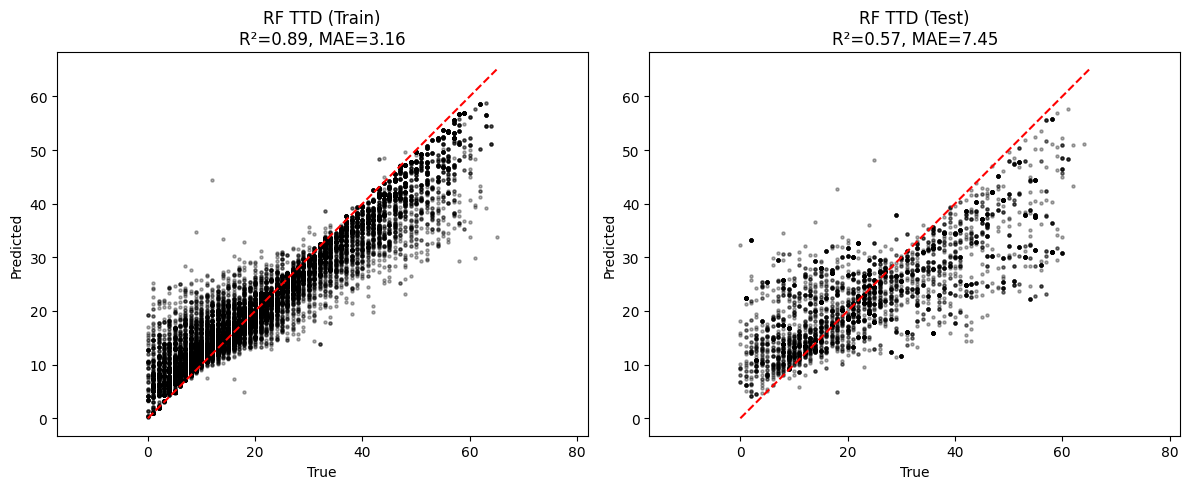

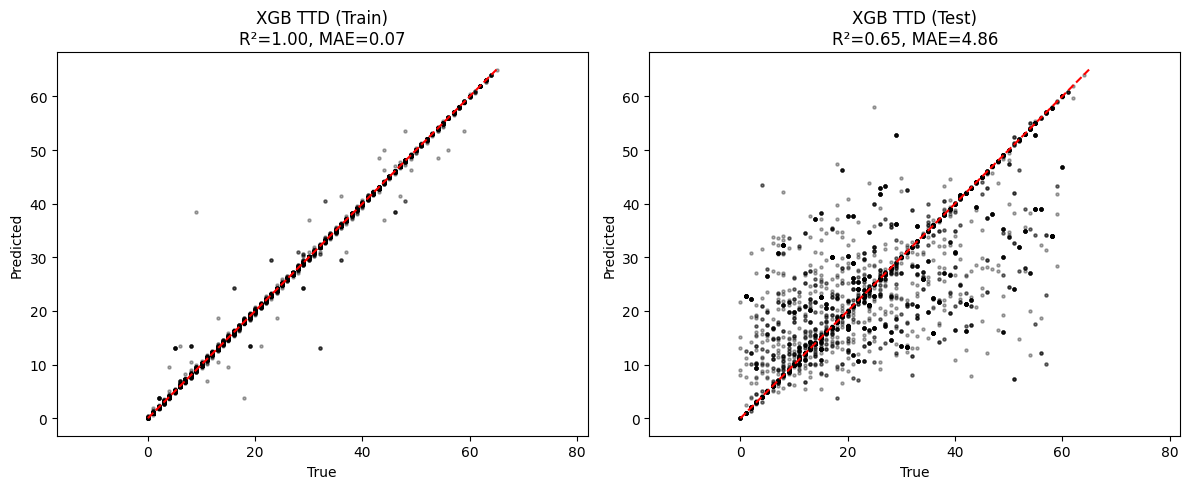

,Task,Model,Split,R²,MAE
0,Time to Death,RF,Train,0.891388,3.158149
1,Time to Death,RF,Test,0.566315,7.449772
2,Time to Death,XGB,Train,0.998757,0.066973
3,Time to Death,XGB,Test,0.652068,4.856268


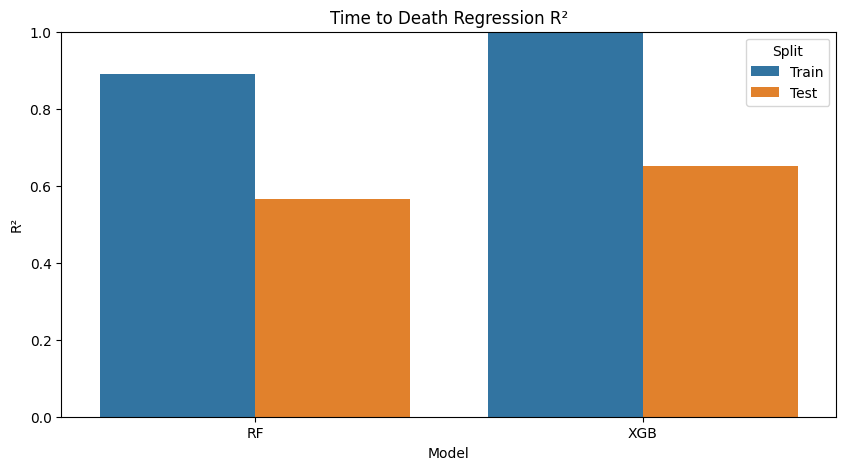

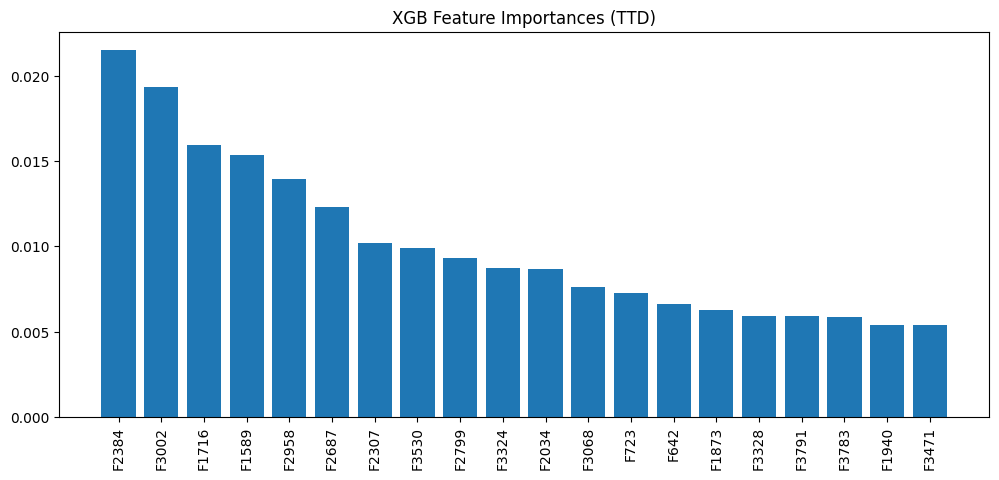

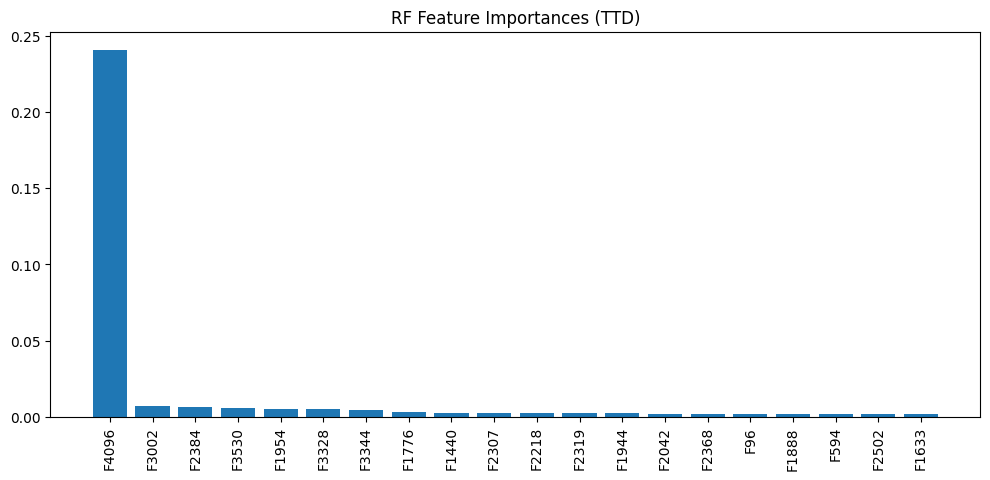

In [ ]:
# 📦 LIBRARIES
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# --- 🧮 CLEAN FEATURES ---
X_clean = X[:, :4098]
y_ttd = y.copy()
groups = df_images["imdb_id"].values
cause_raw = df_images["cause_of_death"].fillna("unknown").values
y_cod = LabelEncoder().fit_transform(cause_raw)

# --- 🔀 TIME-TO-DEATH SPLIT FIRST ---
n_bins = 10
bins_ttd = pd.qcut(y_ttd, q=n_bins, labels=False, duplicates='drop')
sgkf_ttd = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in sgkf_ttd.split(X_clean, bins_ttd, groups):
    break
X_ttd_train, X_ttd_test = X_clean[train_idx], X_clean[test_idx]
y_ttd_train, y_ttd_test = y_ttd[train_idx], y_ttd[test_idx]

# --- 🧬 CAUSE OF DEATH LABELS (after TTD split) ---
cod_counts = Counter(y_cod)
valid_classes = {cls for cls, count in cod_counts.items() if count >= 2}
mask = np.isin(y_cod, list(valid_classes))
X_clean, y_cod, groups = X_clean[mask], y_cod[mask], groups[mask]

# 🔄 Re-split for COD with valid classes
bins_cod = y_cod
sgkf_cod = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for cod_train_idx, cod_test_idx in sgkf_cod.split(X_clean, bins_cod, groups):
    break
X_cod_train, X_cod_test = X_clean[cod_train_idx], X_clean[cod_test_idx]
y_cod_train_raw, y_cod_test_raw = y_cod[cod_train_idx], y_cod[cod_test_idx]

# Fit encoder on training set only
le_cod_split = LabelEncoder()
y_cod_train = le_cod_split.fit_transform(y_cod_train_raw)

# Filter test set to only include labels seen in training set
seen_classes = set(le_cod_split.classes_)
mask_test = np.isin(y_cod_test_raw, list(seen_classes))
X_cod_test = X_cod_test[mask_test]
y_cod_test_raw = y_cod_test_raw[mask_test]
y_cod_test = le_cod_split.transform(y_cod_test_raw)

n_classes = len(le_cod_split.classes_)

# === 🧠 MODELS ===
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
clf_xgb = XGBClassifier(n_estimators=100, max_depth=10, use_label_encoder=False,
                        eval_metric='mlogloss', objective='multi:softprob',
                        num_class=n_classes, n_jobs=-1, random_state=42)
reg_rf = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
reg_xgb = XGBRegressor(n_estimators=100, max_depth=10, n_jobs=-1, verbosity=0, random_state=42)

results = []

# === 🔬 TIME TO DEATH REGRESSION ===
for model, name in [(reg_rf, "RF"), (reg_xgb, "XGB")]:
    model.fit(X_ttd_train, y_ttd_train)
    pred_train = model.predict(X_ttd_train)
    pred_test = model.predict(X_ttd_test)
    r2_train = r2_score(y_ttd_train, pred_train)
    r2_test = r2_score(y_ttd_test, pred_test)
    mae_train = mean_absolute_error(y_ttd_train, pred_train)
    mae_test = mean_absolute_error(y_ttd_test, pred_test)

    results.extend([
        {"Task": "Time to Death", "Model": name, "Split": "Train", "R²": r2_train, "MAE": mae_train},
        {"Task": "Time to Death", "Model": name, "Split": "Test", "R²": r2_test, "MAE": mae_test}
    ])

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_ttd_train, pred_train, s=5, color='black', alpha=0.3)
    plt.plot([y_ttd.min(), y_ttd.max()], [y_ttd.min(), y_ttd.max()], 'r--')
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.title(f"{name} TTD (Train)\nR²={r2_train:.2f}, MAE={mae_train:.2f}")
    plt.axis("equal")

    plt.subplot(1, 2, 2)
    plt.scatter(y_ttd_test, pred_test, s=5, color='black', alpha=0.3)
    plt.plot([y_ttd.min(), y_ttd.max()], [y_ttd.min(), y_ttd.max()], 'r--')
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.title(f"{name} TTD (Test)\nR²={r2_test:.2f}, MAE={mae_test:.2f}")
    plt.axis("equal")
    plt.tight_layout(); plt.show()


# === 📊 RESULTS ===
df_results = pd.DataFrame(results)
display(df_results)

# === 📈 METRIC PLOTS ===
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results[df_results["Task"] == "Time to Death"], x="Model", y="R²", hue="Split")
plt.title("Time to Death Regression R²"); plt.ylim(0, 1); plt.show()

# === 📌 FEATURE IMPORTANCE ===
def plot_feature_importances(model, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-20:][::-1]
    plt.figure(figsize=(12, 5))
    plt.bar([f"F{i}" for i in indices], importances[indices])
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_feature_importances(reg_xgb, "XGB Feature Importances (TTD)")
plot_feature_importances(reg_rf, "RF Feature Importances (TTD)")


In [ ]:
!pip install shap xgboost --quiet

import shap
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.7 MB/s eta 0:00:00


In [ ]:
# 📚 Imports
import os
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
# ✅ Function to generate and show/save maps
def generate_and_show_maps(X, model, df_meta, model_name="XGB", save_dir="maps_full"):
    os.makedirs(save_dir, exist_ok=True)

    feature_names = [f"pixel_{i}" for i in range(4096)] + ["age_at_face", "gender"]
    X_img = X[:, :4096]
    X_full = X[:, :4098]
    image_importances = model.feature_importances_[:4096].reshape(64, 64)

    bins = list(range(0, 101, 10))
    df_meta["ttd_bin"] = pd.cut(df_meta["time_to_death"], bins=bins, right=False)

    group_masks = {
        "all": np.ones(len(df_meta), dtype=bool),
        "male": df_meta["gender"] == 0,
        "female": df_meta["gender"] == 1,
    }

    explainer = shap.Explainer(model)
    shap_values = explainer(X_full)

    for group_label, gender_mask in group_masks.items():
        for bin_range in df_meta["ttd_bin"].cat.categories:
            bin_mask = df_meta["ttd_bin"] == bin_range
            idx = np.where(gender_mask & bin_mask)[0]

            if len(idx) == 0:
                avg_face = np.zeros((64, 64))
                shap_map = np.zeros((64, 64))
            else:
                avg_face = X_img[idx].mean(axis=0).reshape(64, 64)
                shap_vals_img = shap_values.values[idx][:, :4096]
                shap_map = np.mean(shap_vals_img, axis=0).reshape(64, 64)

            overlay = np.clip(avg_face / 255.0, 0, 1)

            # SHAP Map
            plt.figure(figsize=(6, 6))
            plt.imshow(overlay, cmap="gray")
            plt.imshow(shap_map, cmap="bwr", alpha=0.6,
                       vmin=-np.max(np.abs(shap_map)), vmax=np.max(np.abs(shap_map)))
            plt.title(f"SHAP — {model_name} — {group_label} — {bin_range}")
            plt.axis("off")
            plt.colorbar(label="SHAP Value")
            plt.savefig(f"{save_dir}/{model_name}_shap_{group_label}_{bin_range}.png", bbox_inches='tight')
            plt.show()

            # Feature Importance Map
            plt.figure(figsize=(6, 6))
            plt.imshow(overlay, cmap="gray")
            plt.imshow(image_importances, cmap="inferno", alpha=0.5)
            plt.title(f"Importance — {model_name} — {group_label} — {bin_range}")
            plt.axis("off")
            plt.colorbar(label="Feature Importance")
            plt.savefig(f"{save_dir}/{model_name}_importance_{group_label}_{bin_range}.png", bbox_inches='tight')
            plt.show()

In [ ]:
df_images

,name,age_at_face,age_at_death,time_to_death_at_face,cause_of_death,imdb_id,gender,image_file
0,Fred Astaire,68,88,20,unknown,nm0000001,NaN,nm0000001_rm577153792_1899-5-10_1968.jpg
1,Fred Astaire,70,88,18,unknown,nm0000001,NaN,nm0000001_rm577153792_1899-5-10_1968.jpg
2,Fred Astaire,68,88,20,unknown,nm0000001,NaN,nm0000001_rm577153792_1899-5-10_1968.jpg
3,Fred Astaire,68,88,20,unknown,nm0000001,NaN,nm0000001_rm577153792_1899-5-10_1968.jpg
4,Fred Astaire,68,88,20,unknown,nm0000001,NaN,nm0000001_rm577153792_1899-5-10_1968.jpg
...,...,...,...,...,...,...,...,...
23504,Frank McRae,39,77,38,unknown,nm0574433,NaN,nm0574433_rm708021760_1942-6-3_1982.jpg
23505,Frank McRae,39,77,38,unknown,nm0574433,NaN,nm0574433_rm708021760_1942-6-3_1982.jpg
23506,Daliah Lavi,26,75,49,disease,nm0492002,NaN,nm0492002_rm2093057280_1940-10-12_1967.jpg
23507,Daliah Lavi,22,75,53,disease,nm0492002,NaN,nm0492002_rm3600339712_1940-10-12_1963.jpg


In [ ]:
generate_and_show_maps(X_clean, reg_rf, df_images, model_name="RF")
generate_and_show_maps(X_clean, reg_xgb, df_images, model_name="XGB")


KeyError: 'time_to_death'

In [ ]:
df_images["time_to_death"] = df_images["time_to_death_at_face"]


In [ ]:
def generate_and_show_maps_nogender(X, model, df_meta, model_name="XGB", save_dir="maps_nogender"):
    import shap
    os.makedirs(save_dir, exist_ok=True)

    feature_names = [f"pixel_{i}" for i in range(4096)] + ["age_at_face", "gender"]
    X_img = X[:, :4096]
    X_full = X[:, :4098]
    image_importances = model.feature_importances_[:4096].reshape(64, 64)

    # Use time_to_death for binning
    bins = list(range(0, 101, 10))
    df_meta["ttd_bin"] = pd.cut(df_meta["time_to_death"], bins=bins, right=False)

    explainer = shap.Explainer(model)
    shap_values = explainer(X_full)

    for bin_range in df_meta["ttd_bin"].cat.categories:
        bin_mask = df_meta["ttd_bin"] == bin_range
        idx = np.where(bin_mask)[0]

        if len(idx) == 0:
            avg_face = np.zeros((64, 64))
            shap_map = np.zeros((64, 64))
        else:
            avg_face = X_img[idx].mean(axis=0).reshape(64, 64)
            shap_vals_img = shap_values.values[idx][:, :4096]
            shap_map = np.mean(shap_vals_img, axis=0).reshape(64, 64)

        overlay = np.clip(avg_face / 255.0, 0, 1)

        # SHAP Map
        plt.figure(figsize=(6, 6))
        plt.imshow(overlay, cmap="gray")
        plt.imshow(shap_map, cmap="bwr", alpha=0.6,
                   vmin=-np.max(np.abs(shap_map)), vmax=np.max(np.abs(shap_map)))
        plt.title(f"SHAP — {model_name} — {bin_range}")
        plt.axis("off")
        plt.colorbar(label="SHAP Value")
        plt.savefig(f"{save_dir}/{model_name}_shap_{bin_range}.png", bbox_inches='tight')
        plt.show()

        # Feature Importance Map
        plt.figure(figsize=(6, 6))
        plt.imshow(overlay, cmap="gray")
        plt.imshow(image_importances, cmap="inferno", alpha=0.5)
        plt.title(f"Importance — {model_name} — {bin_range}")
        plt.axis("off")
        plt.colorbar(label="Feature Importance")
        plt.savefig(f"{save_dir}/{model_name}_importance_{bin_range}.png", bbox_inches='tight')
        plt.show()

    print(f"✅ All SHAP and importance maps saved to {save_dir}")

# Run for both models without gender stratification
generate_and_show_maps_nogender(X_clean, reg_rf, df_images, model_name="RF")
generate_and_show_maps_nogender(X_clean, reg_xgb, df_images, model_name="XGB")


IndexError: index 23500 is out of bounds for axis 0 with size 23477

run here

In [ ]:
# 📦 LIBRARIES
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# --- 🧮 CLEAN FEATURES ---
X_clean = X[:, :4098]
y_ttd = y.copy()
groups = df_images["imdb_id"].values
cause_raw = df_images["cause_of_death"].fillna("unknown").values
y_cod = LabelEncoder().fit_transform(cause_raw)

# --- 🔀 TIME-TO-DEATH SPLIT FIRST ---
n_bins = 10
bins_ttd = pd.qcut(y_ttd, q=n_bins, labels=False, duplicates='drop')
sgkf_ttd = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in sgkf_ttd.split(X_clean, bins_ttd, groups):
    break
X_ttd_train, X_ttd_test = X_clean[train_idx], X_clean[test_idx]
y_ttd_train, y_ttd_test = y_ttd[train_idx], y_ttd[test_idx]

# --- 🧬 CAUSE OF DEATH LABELS (after TTD split) ---
cod_counts = Counter(y_cod)
valid_classes = {cls for cls, count in cod_counts.items() if count >= 2}
mask = np.isin(y_cod, list(valid_classes))
X_clean, y_cod, groups = X_clean[mask], y_cod[mask], groups[mask]

# 🔄 Re-split for COD with valid classes
bins_cod = y_cod
sgkf_cod = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
for cod_train_idx, cod_test_idx in sgkf_cod.split(X_clean, bins_cod, groups):
    break
X_cod_train, X_cod_test = X_clean[cod_train_idx], X_clean[cod_test_idx]
y_cod_train_raw, y_cod_test_raw = y_cod[cod_train_idx], y_cod[cod_test_idx]

# Fit encoder on training set only
le_cod_split = LabelEncoder()
y_cod_train = le_cod_split.fit_transform(y_cod_train_raw)

# Filter test set to only include labels seen in training set
seen_classes = set(le_cod_split.classes_)
mask_test = np.isin(y_cod_test_raw, list(seen_classes))
X_cod_test = X_cod_test[mask_test]
y_cod_test_raw = y_cod_test_raw[mask_test]
y_cod_test = le_cod_split.transform(y_cod_test_raw)

n_classes = len(le_cod_split.classes_)

# === 🧠 MODELS ===
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
clf_xgb = XGBClassifier(n_estimators=100, max_depth=10, use_label_encoder=False,
                        eval_metric='mlogloss', objective='multi:softprob',
                        num_class=n_classes, n_jobs=-1, random_state=42)
reg_rf = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
reg_xgb = XGBRegressor(n_estimators=100, max_depth=10, n_jobs=-1, verbosity=0, random_state=42)

results = []

# === 🔬 TIME TO DEATH REGRESSION ===
for model, name in [(reg_rf, "RF"), (reg_xgb, "XGB")]:
    model.fit(X_ttd_train, y_ttd_train)
    pred_train = model.predict(X_ttd_train)
    pred_test = model.predict(X_ttd_test)
    r2_train = r2_score(y_ttd_train, pred_train)
    r2_test = r2_score(y_ttd_test, pred_test)
    mae_train = mean_absolute_error(y_ttd_train, pred_train)
    mae_test = mean_absolute_error(y_ttd_test, pred_test)

    results.extend([
        {"Task": "Time to Death", "Model": name, "Split": "Train", "R²": r2_train, "MAE": mae_train},
        {"Task": "Time to Death", "Model": name, "Split": "Test", "R²": r2_test, "MAE": mae_test}
    ])

    # Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_ttd_train, pred_train, s=5, color='black', alpha=0.3)
    plt.plot([y_ttd.min(), y_ttd.max()], [y_ttd.min(), y_ttd.max()], 'r--')
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.title(f"{name} TTD (Train)\nR²={r2_train:.2f}, MAE={mae_train:.2f}")
    plt.axis("equal")

    plt.subplot(1, 2, 2)
    plt.scatter(y_ttd_test, pred_test, s=5, color='black', alpha=0.3)
    plt.plot([y_ttd.min(), y_ttd.max()], [y_ttd.min(), y_ttd.max()], 'r--')
    plt.xlabel("True"); plt.ylabel("Predicted")
    plt.title(f"{name} TTD (Test)\nR²={r2_test:.2f}, MAE={mae_test:.2f}")
    plt.axis("equal")
    plt.tight_layout(); plt.show()


# === 📊 RESULTS ===
df_results = pd.DataFrame(results)
display(df_results)

# === 📈 METRIC PLOTS ===
plt.figure(figsize=(10, 5))
sns.barplot(data=df_results[df_results["Task"] == "Time to Death"], x="Model", y="R²", hue="Split")
plt.title("Time to Death Regression R²"); plt.ylim(0, 1); plt.show()

# === 📌 FEATURE IMPORTANCE ===
def plot_feature_importances(model, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-20:][::-1]
    plt.figure(figsize=(12, 5))
    plt.bar([f"F{i}" for i in indices], importances[indices])
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

plot_feature_importances(reg_xgb, "XGB Feature Importances (TTD)")
plot_feature_importances(reg_rf, "RF Feature Importances (TTD)")


In [ ]:
def generate_feature_importance_maps_by_bin(X, model, df_meta, model_name="XGB", save_dir="maps_importance_only"):
    os.makedirs(save_dir, exist_ok=True)

    X_img = X[:, :4096]
    X_full = X[:, :4098]
    image_importances = model.feature_importances_[:4096].reshape(64, 64)

    # Bin by time-to-death
    bins = list(range(0, 101, 10))
    df_meta["ttd_bin"] = pd.cut(df_meta["time_to_death"], bins=bins, right=False)

    for bin_range in df_meta["ttd_bin"].cat.categories:
        idx = np.where(df_meta["ttd_bin"] == bin_range)[0]

        if len(idx) == 0:
            avg_face = np.zeros((64, 64))
        else:
            avg_face = X_img[idx].mean(axis=0).reshape(64, 64)

        overlay = np.clip(avg_face / 255.0, 0, 1)

        # Importance plot
        plt.figure(figsize=(6, 6))
        plt.imshow(overlay, cmap="gray")
        plt.imshow(image_importances, cmap="inferno", alpha=0.5)
        plt.title(f"Feature Importance — {model_name} — {bin_range}")
        plt.axis("off")
        plt.colorbar(label="Importance")
        plt.savefig(f"{save_dir}/{model_name}_importance_only_{bin_range}.png", bbox_inches='tight')
        plt.show()

    print(f"✅ Feature importance maps saved to {save_dir}")


In [ ]:
generate_feature_importance_maps_by_bin(X_clean, reg_rf, df_images, model_name="RF")
generate_feature_importance_maps_by_bin(X_clean, reg_xgb, df_images, model_name="XGB")
